In [7]:
import sys
sys.path.append("../")  

import numpy as np 
import math, torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR, MultiplicativeLR
import torch.nn as nn
import matplotlib.pyplot as plt
import sys, os
import mpl_toolkits.mplot3d as p3d
from scipy.linalg import lstsq
import utility, problem, net
import random

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# 设置随机种子
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def trainnew(model,problem,device,params,optimizer,scheduler,bdry_penalty="False"):
    
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    ranks = []
    singular_values = []
    error_l2s = []
    error_l2_rels = []
    interior_losses = []
    steps = []  
    initialloss = 1
    model.train()
    for step in range(0, params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        model.zero_grad()
        problem.loss_int(u, int_data)
        problem.loss_bdry(u_bdry, bdry_data)
        loss_pde = problem.loss_pde()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_pde + loss_orthogonal*params["orthogonalpenalty"] 
        
        if step == 1:
            initialloss = loss_pde.detach().cpu().numpy()
            print("Initial pde loss is %s"%(initialloss))
        else:
            if loss_pde.detach().cpu().numpy()/initialloss < params["epsilon"]:
                print("Final pde loss at Step %s is %s"%(step+1,loss_pde.detach().cpu().numpy()))
                break

        if step%params["writeStep"] == 1:
            rank = torch.linalg.matrix_rank(u_second)
            ranks.append(rank.cpu().numpy())
            print("Error at Step %s is %s with pde loss %s, orthogonal loss %s and rank of matrix %s."%(step,loss.detach().cpu().numpy(),loss_pde, loss_orthogonal.detach().cpu().numpy(),rank.cpu().numpy()))
            
        
        if step%params["plotStep"] == 1:
            tem = lambda x: model(x)[1]
            problem.plot(tem)
            # U, S, Vh = torch.linalg.svd(u_second)
            # singular_values.append(S.detach().cpu().numpy())
            # steps.append([step] * len(S)) 
        
        if step%params["lsStep"] == 1: 
            print("-----------------------------at step %s ----------------------------------"%(step))
            print("the interior loss is %s"%(loss_pde.detach().cpu().numpy()))
            w = utility.leastsquare(model, int_data, bdry_data, params, device, problem, bdry_penalty)
            perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
            error_l2, error_l2_rel = problem.plot(perdict)
            interior_losses.append(loss_pde.detach().cpu().numpy())
            error_l2s.append(error_l2)
            error_l2_rels.append(error_l2_rel)

        loss.backward()
        optimizer.step()
        scheduler.step()
    # singular_values = np.concatenate(singular_values)  # 转换为一维数组
    # steps = np.concatenate(steps)
    # plt.scatter(steps, singular_values, color="blue", s=10)
    # plt.ylabel("Singular Values")
    # plt.xlabel("Step")
    # plt.title("Change of Singular Values")
    # plt.show()
    # A = (u_second.T @ u_second- torch.eye(params["dd"]).to(device).double()).detach().cpu().numpy()
    # print("the rank of basis matrix: ", torch.linalg.matrix_rank(u_second).cpu().numpy())
    # print("the maximum of the absolute error between utu and I: ", np.max(np.abs(A)))
    # print("the average of the absolute error between utu and I: ", np.mean(np.abs(A)))
    # print("----------------------------------------------------------------")
    w = utility.leastsquare(model, int_data, bdry_data, params, device, problem, bdry_penalty)
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    return error_l2s, error_l2_rels, interior_losses

In [9]:
torch.set_default_dtype(torch.float64)

def u_exact(x):
    return torch.sin(3*torch.pi*x+3*torch.pi/20)*torch.cos(2*torch.pi*x+torch.pi/10)+2

def f(x):
    return -13*torch.pi**2*torch.sin(3*torch.pi*x+3*torch.pi/20)*torch.cos(2*torch.pi*x+torch.pi/10) - 12*torch.pi**2*torch.cos(3*torch.pi*x+3*torch.pi/20)*torch.sin(2*torch.pi*x+torch.pi/10) - 10*u_exact(x)


Initial pde loss is 8657.580767742635
Error at Step 1 is 8657.580767742635 with pde loss tensor(8657.5808, device='cuda:0', grad_fn=<AddBackward0>), orthogonal loss 703.8751534371959 and rank of matrix 14.
the maximum pointwise error in problem helmholtz1d:  2.910014854027468
the l2 relative error in problem helmholtz1d:  0.9869091119046606


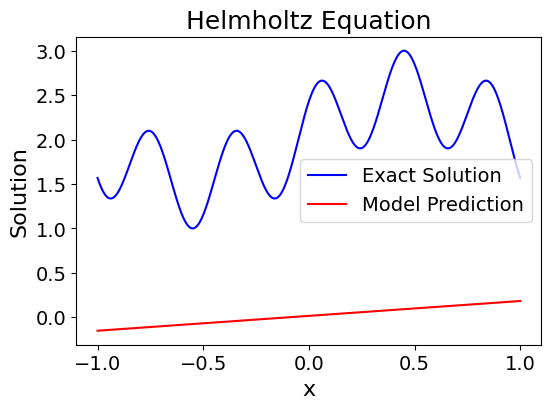

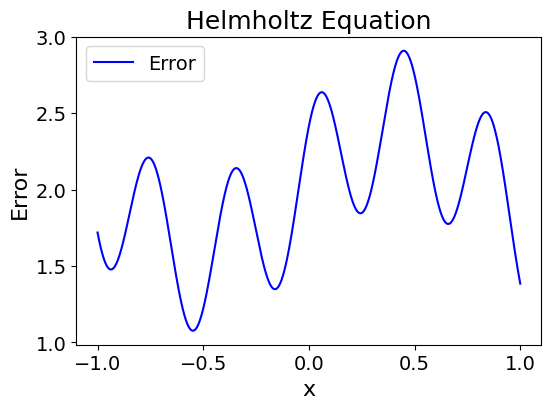

-----------------------------at step 1 ----------------------------------
the interior loss is 8657.580767742635
the error of least square in problem helmholtz1d:  19.529490026956335
the condition number of matrix A in problem helmholtz1d:  2.1143888069766227e+17
the rank of matrix A in problem helmholtz1d:  16
the maximum pointwise error in problem helmholtz1d:  0.5824435619360928
the l2 relative error in problem helmholtz1d:  0.08690224483605227


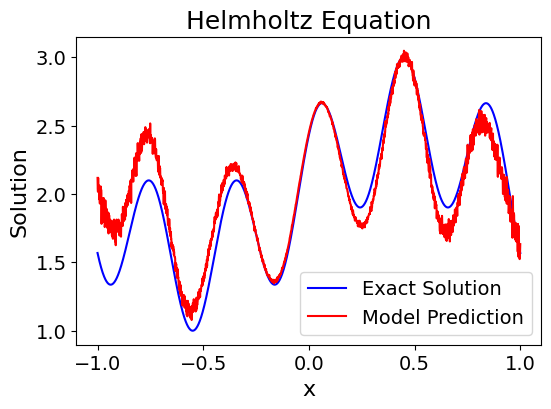

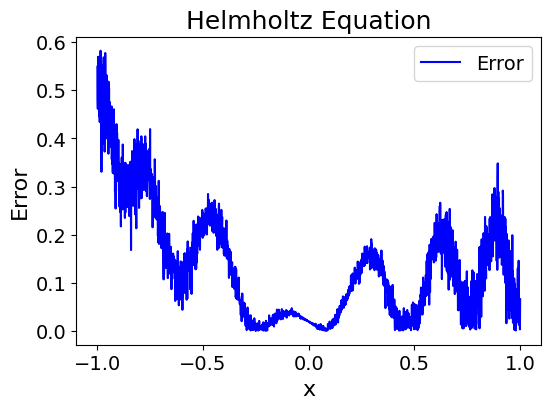

-----------------------------at step 11 ----------------------------------
the interior loss is 8551.768192512125
the error of least square in problem helmholtz1d:  1.3178874696240424
the condition number of matrix A in problem helmholtz1d:  1.879061014441643e+16
the rank of matrix A in problem helmholtz1d:  20
the maximum pointwise error in problem helmholtz1d:  0.015540035586353529
the l2 relative error in problem helmholtz1d:  0.002965729340452112


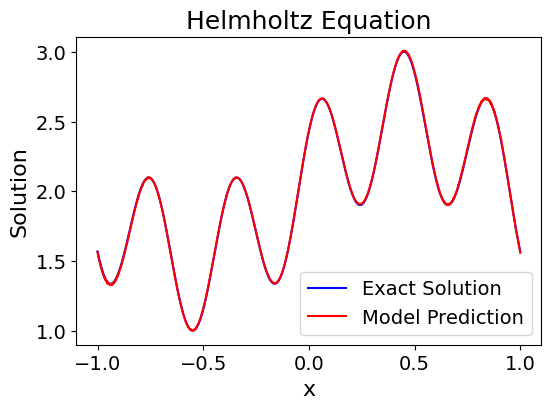

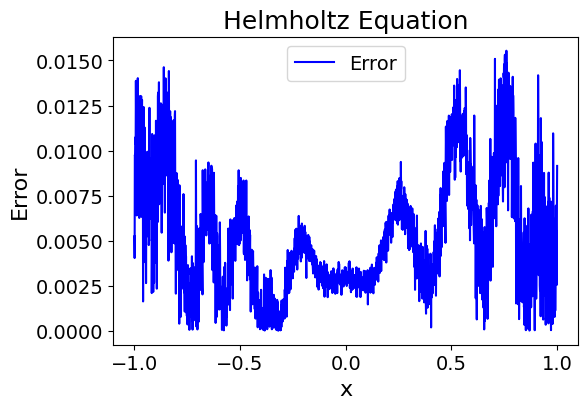

-----------------------------at step 21 ----------------------------------
the interior loss is 8391.38237444953
the error of least square in problem helmholtz1d:  5.958380084662288e-06
the condition number of matrix A in problem helmholtz1d:  1.726372282123512e+16
the rank of matrix A in problem helmholtz1d:  28
the maximum pointwise error in problem helmholtz1d:  8.146039105483283e-07
the l2 relative error in problem helmholtz1d:  4.9963816655095656e-08


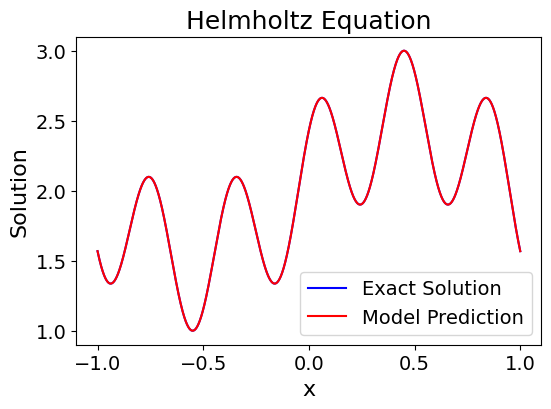

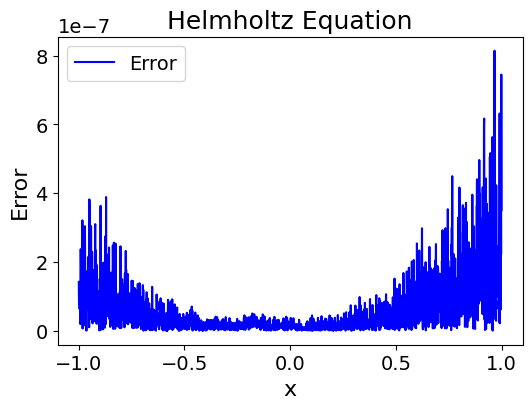

-----------------------------at step 31 ----------------------------------
the interior loss is 8209.002059634877
the error of least square in problem helmholtz1d:  3.4973197820667927e-08
the condition number of matrix A in problem helmholtz1d:  1.935709523154951e+16
the rank of matrix A in problem helmholtz1d:  36
the maximum pointwise error in problem helmholtz1d:  1.2708170959996323e-08
the l2 relative error in problem helmholtz1d:  1.2704893726776795e-09


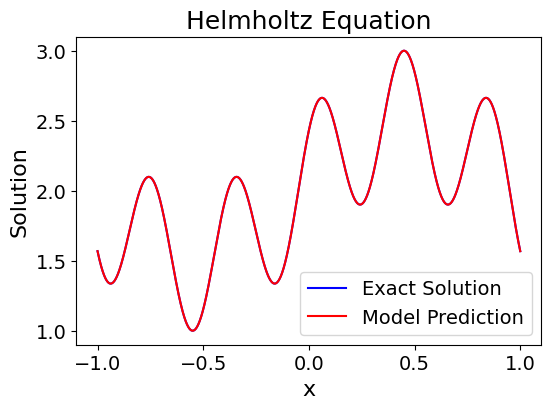

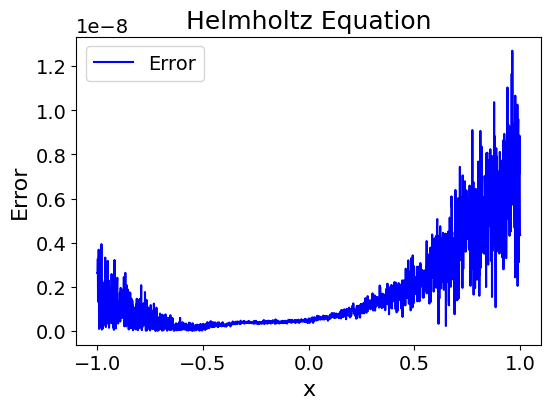

-----------------------------at step 41 ----------------------------------
the interior loss is 7838.758737541434
the error of least square in problem helmholtz1d:  2.5858363247936667e-08
the condition number of matrix A in problem helmholtz1d:  2.213184375150176e+16
the rank of matrix A in problem helmholtz1d:  41
the maximum pointwise error in problem helmholtz1d:  1.0259264993095485e-08
the l2 relative error in problem helmholtz1d:  1.3377464987734466e-09


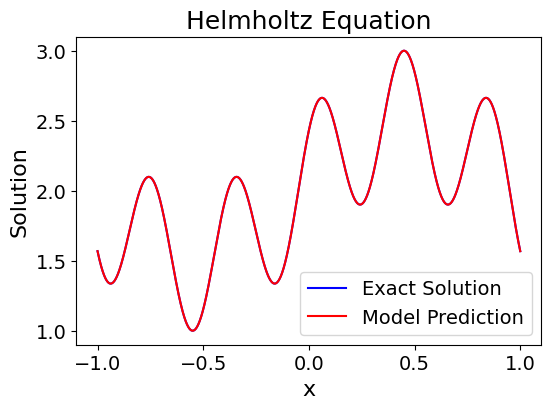

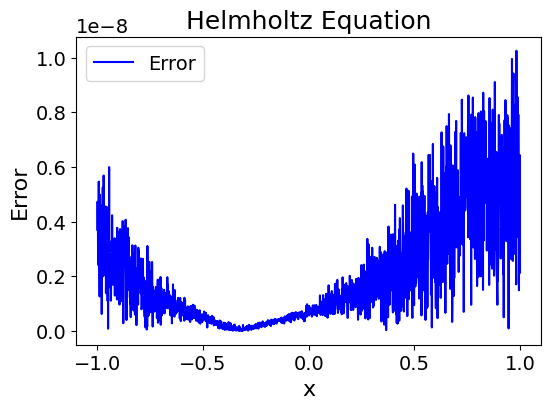

-----------------------------at step 51 ----------------------------------
the interior loss is 7402.673289203352
the error of least square in problem helmholtz1d:  4.379882059637415e-08
the condition number of matrix A in problem helmholtz1d:  2.5383603562540052e+16
the rank of matrix A in problem helmholtz1d:  46
the maximum pointwise error in problem helmholtz1d:  1.3376063812131633e-08
the l2 relative error in problem helmholtz1d:  1.9456799458663537e-09


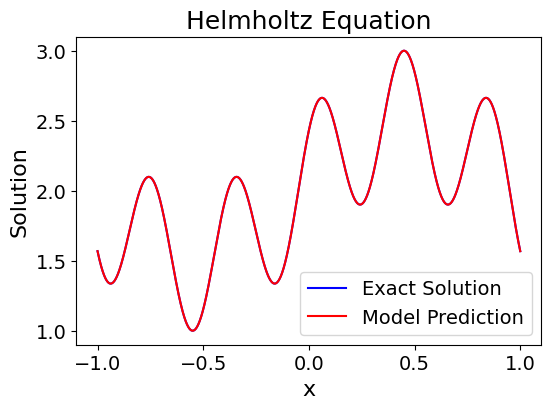

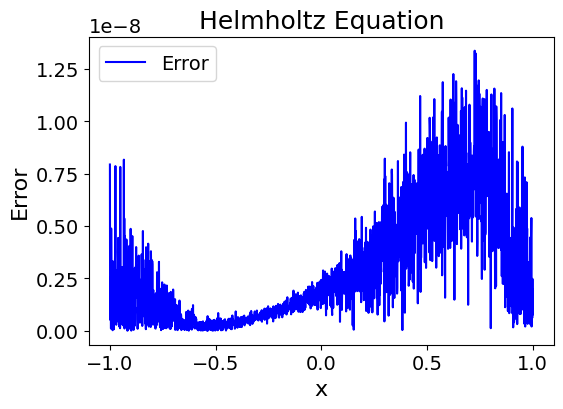

-----------------------------at step 61 ----------------------------------
the interior loss is 6731.392383816537
the error of least square in problem helmholtz1d:  1.2980484104345942e-08
the condition number of matrix A in problem helmholtz1d:  1.9703868281220028e+16
the rank of matrix A in problem helmholtz1d:  50
the maximum pointwise error in problem helmholtz1d:  6.553633635775213e-09
the l2 relative error in problem helmholtz1d:  1.0196985282392962e-09


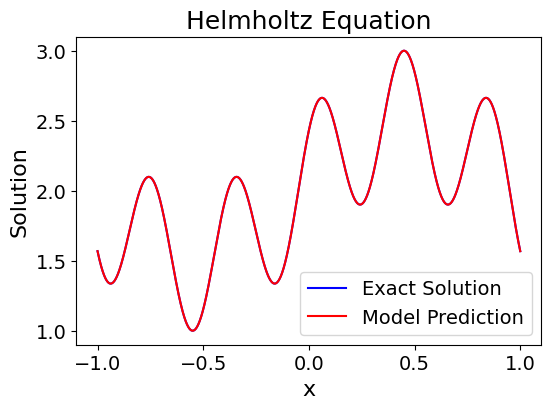

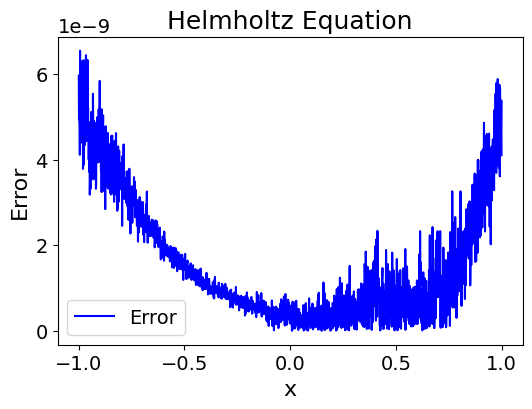

-----------------------------at step 71 ----------------------------------
the interior loss is 5616.575287815977
the error of least square in problem helmholtz1d:  5.948795238671909e-09
the condition number of matrix A in problem helmholtz1d:  2.144569468888682e+16
the rank of matrix A in problem helmholtz1d:  58
the maximum pointwise error in problem helmholtz1d:  1.6219385834403965e-09
the l2 relative error in problem helmholtz1d:  2.4947009065715886e-10


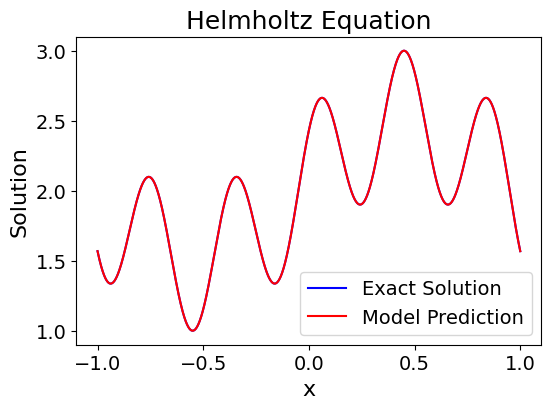

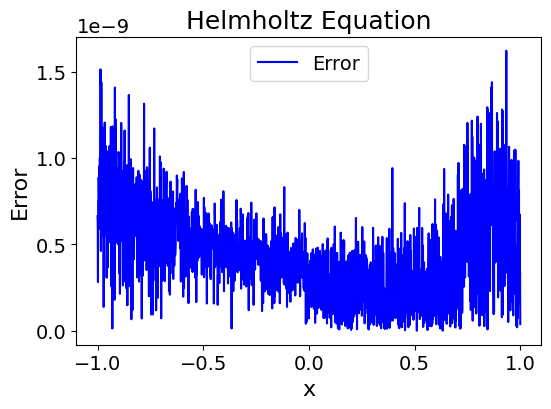

-----------------------------at step 81 ----------------------------------
the interior loss is 3518.84180943898
the error of least square in problem helmholtz1d:  6.65355156689864e-10
the condition number of matrix A in problem helmholtz1d:  1.496481916111462e+16
the rank of matrix A in problem helmholtz1d:  71
the maximum pointwise error in problem helmholtz1d:  2.851372471468494e-10
the l2 relative error in problem helmholtz1d:  5.512189106949697e-11


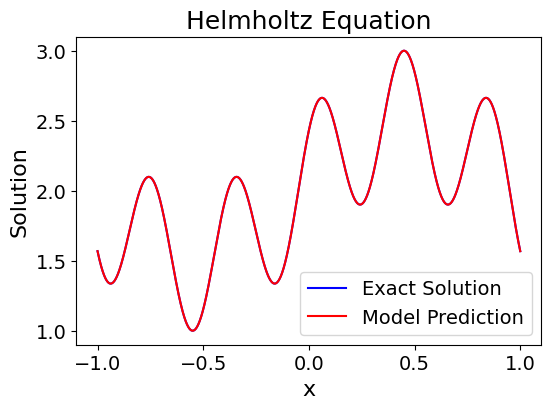

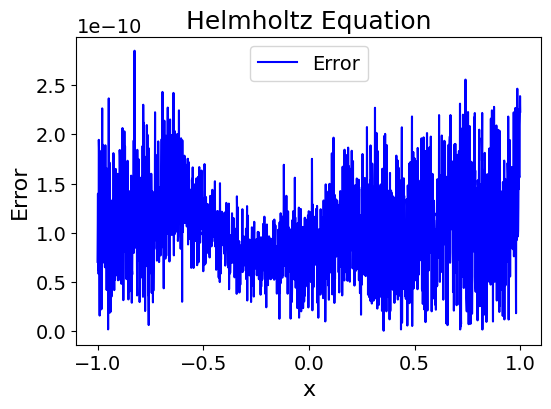

-----------------------------at step 91 ----------------------------------
the interior loss is 655.9830383477154
the error of least square in problem helmholtz1d:  1.2199049052147e-10
the condition number of matrix A in problem helmholtz1d:  1.9018665110961216e+16
the rank of matrix A in problem helmholtz1d:  87
the maximum pointwise error in problem helmholtz1d:  7.771028265324276e-11
the l2 relative error in problem helmholtz1d:  9.678422897884432e-12


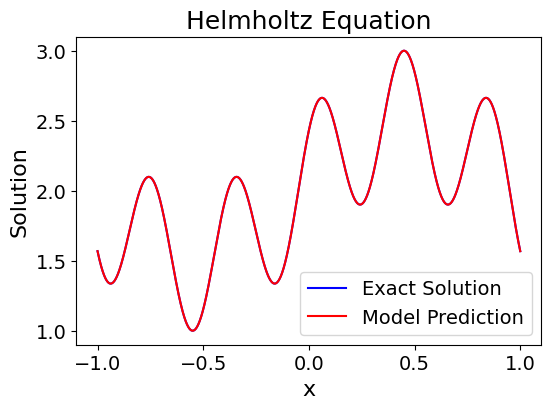

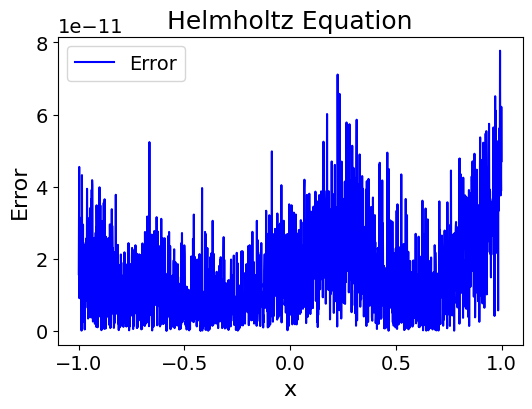

-----------------------------at step 101 ----------------------------------
the interior loss is 240.04550047855648
the error of least square in problem helmholtz1d:  1.752468467724365e-11
the condition number of matrix A in problem helmholtz1d:  1.8014996636562596e+16
the rank of matrix A in problem helmholtz1d:  94
the maximum pointwise error in problem helmholtz1d:  5.81481529593475e-11
the l2 relative error in problem helmholtz1d:  7.520902616971763e-12


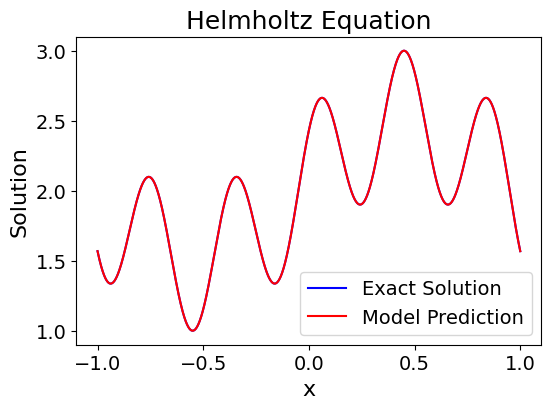

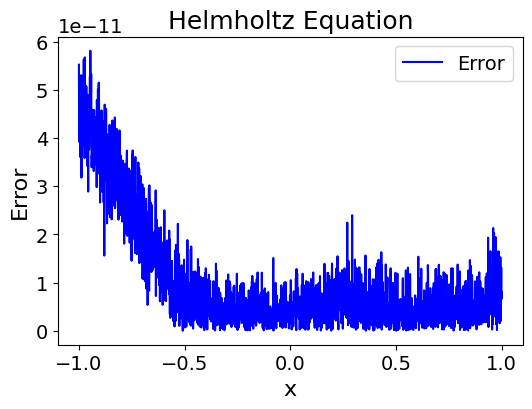

-----------------------------at step 111 ----------------------------------
the interior loss is 113.17786864203981
the error of least square in problem helmholtz1d:  2.5365666249998504e-11
the condition number of matrix A in problem helmholtz1d:  1.5305971725113748e+16
the rank of matrix A in problem helmholtz1d:  95
the maximum pointwise error in problem helmholtz1d:  2.3586910202766376e-11
the l2 relative error in problem helmholtz1d:  4.183657306968911e-12


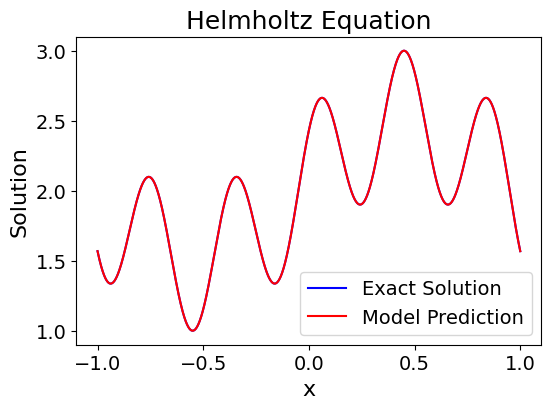

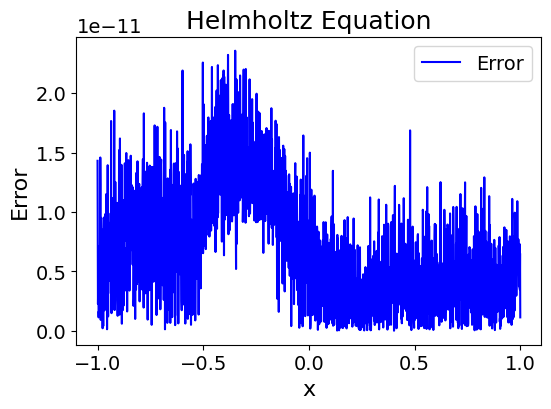

-----------------------------at step 121 ----------------------------------
the interior loss is 57.03544636987155
the error of least square in problem helmholtz1d:  4.47191032434937e-11
the condition number of matrix A in problem helmholtz1d:  1.3966488684870454e+16
the rank of matrix A in problem helmholtz1d:  96
the maximum pointwise error in problem helmholtz1d:  3.2017943851769815e-11
the l2 relative error in problem helmholtz1d:  6.72042077883197e-12


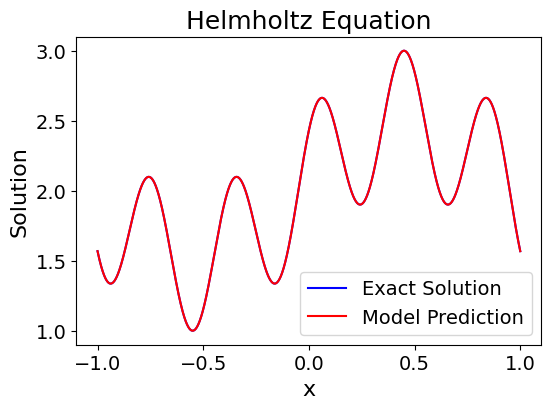

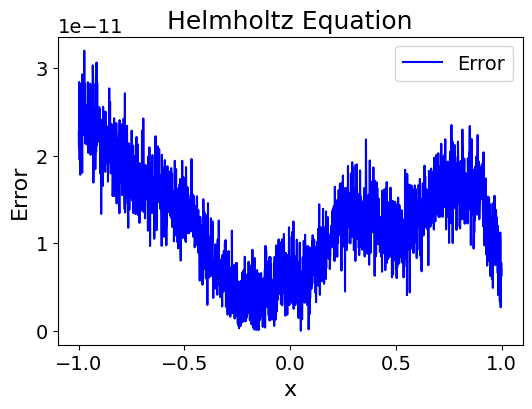

-----------------------------at step 131 ----------------------------------
the interior loss is 35.81643942754329
the error of least square in problem helmholtz1d:  2.9890632178166015e-11
the condition number of matrix A in problem helmholtz1d:  1.4269020627820412e+16
the rank of matrix A in problem helmholtz1d:  97
the maximum pointwise error in problem helmholtz1d:  2.5007107495866876e-11
the l2 relative error in problem helmholtz1d:  4.595358600332801e-12


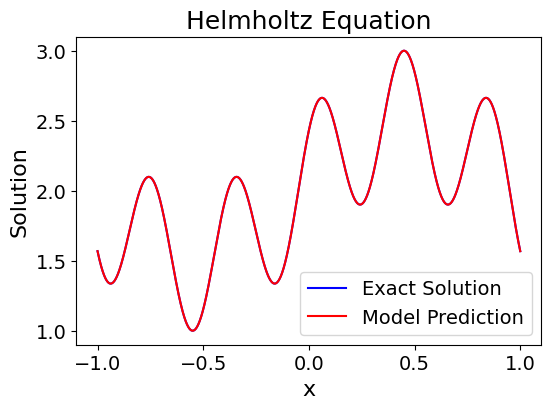

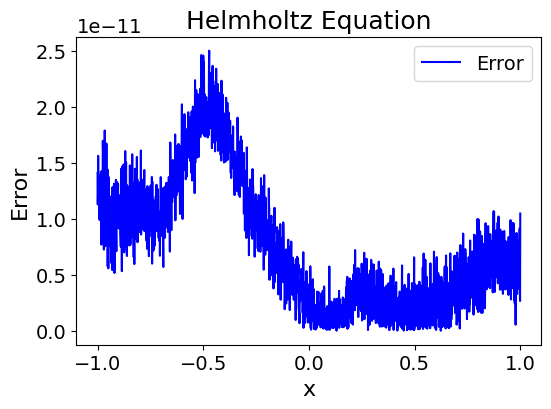

-----------------------------at step 141 ----------------------------------
the interior loss is 23.427282975227264
the error of least square in problem helmholtz1d:  3.91600252488007e-11
the condition number of matrix A in problem helmholtz1d:  1.2897791296607494e+16
the rank of matrix A in problem helmholtz1d:  98
the maximum pointwise error in problem helmholtz1d:  2.0054180538409128e-11
the l2 relative error in problem helmholtz1d:  3.5074940495962647e-12


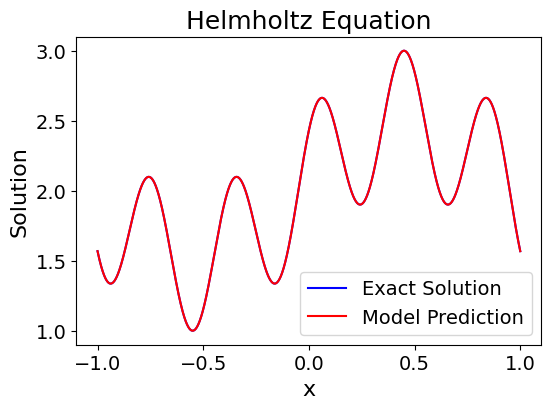

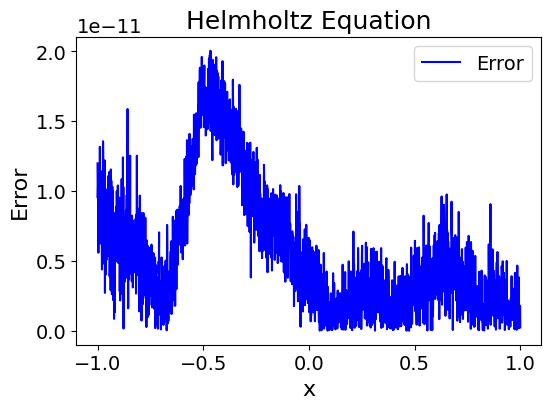

-----------------------------at step 151 ----------------------------------
the interior loss is 17.366260374533745
the error of least square in problem helmholtz1d:  1.1729239377176964e-11
the condition number of matrix A in problem helmholtz1d:  1.5841065000587604e+16
the rank of matrix A in problem helmholtz1d:  98
the maximum pointwise error in problem helmholtz1d:  1.8643975252530254e-11
the l2 relative error in problem helmholtz1d:  2.8696908155176584e-12


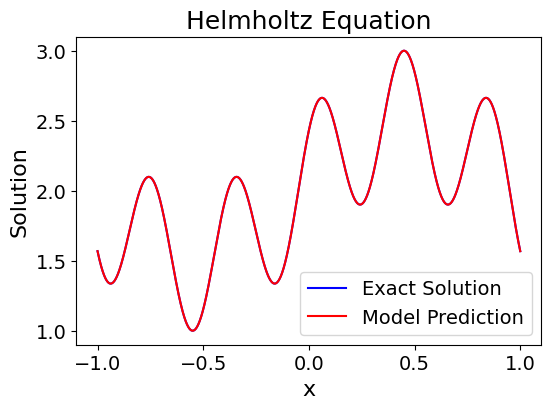

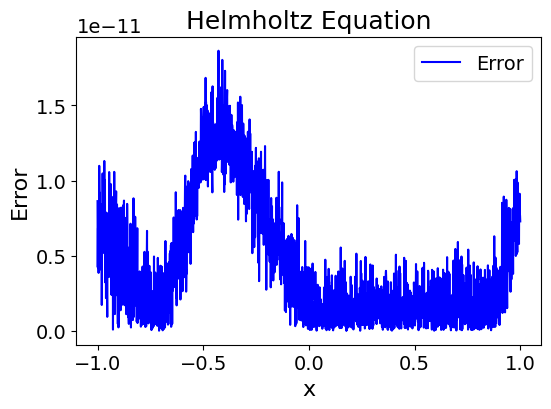

-----------------------------at step 161 ----------------------------------
the interior loss is 13.404120326971668
the error of least square in problem helmholtz1d:  4.227009975916806e-11
the condition number of matrix A in problem helmholtz1d:  1.7570437102714104e+16
the rank of matrix A in problem helmholtz1d:  99
the maximum pointwise error in problem helmholtz1d:  2.8271607277474686e-11
the l2 relative error in problem helmholtz1d:  5.7620222348891185e-12


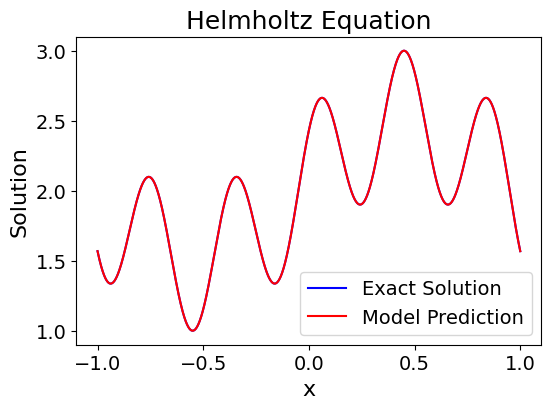

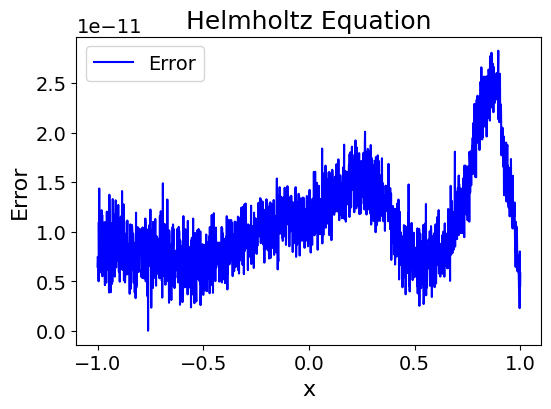

-----------------------------at step 171 ----------------------------------
the interior loss is 10.545477935564382
the error of least square in problem helmholtz1d:  3.693254713459212e-11
the condition number of matrix A in problem helmholtz1d:  1.7618788729184286e+16
the rank of matrix A in problem helmholtz1d:  99
the maximum pointwise error in problem helmholtz1d:  2.311617564032531e-11
the l2 relative error in problem helmholtz1d:  5.39894673430453e-12


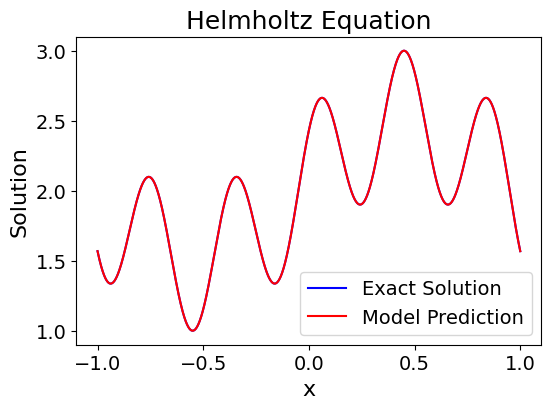

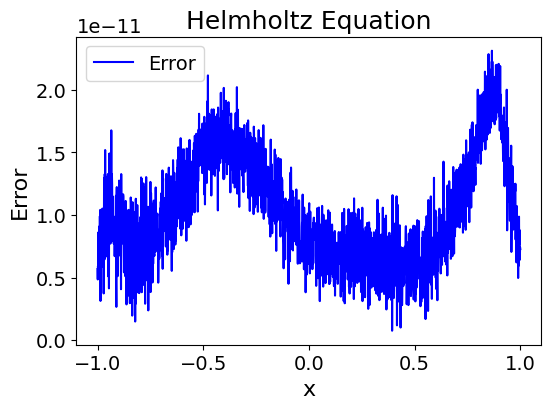

-----------------------------at step 181 ----------------------------------
the interior loss is 8.65360646270703
the error of least square in problem helmholtz1d:  3.2856564653553306e-11
the condition number of matrix A in problem helmholtz1d:  1.31962480600888e+16
the rank of matrix A in problem helmholtz1d:  99
the maximum pointwise error in problem helmholtz1d:  2.6612934078684702e-11
the l2 relative error in problem helmholtz1d:  4.370510804465459e-12


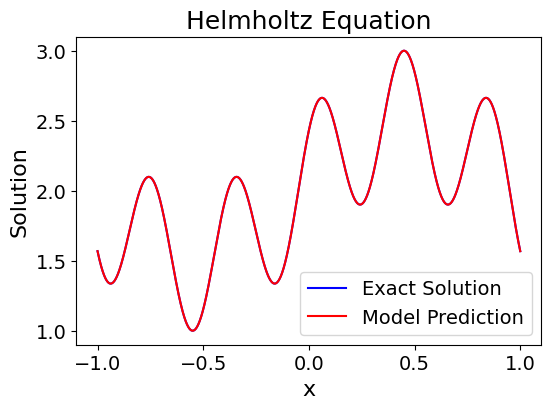

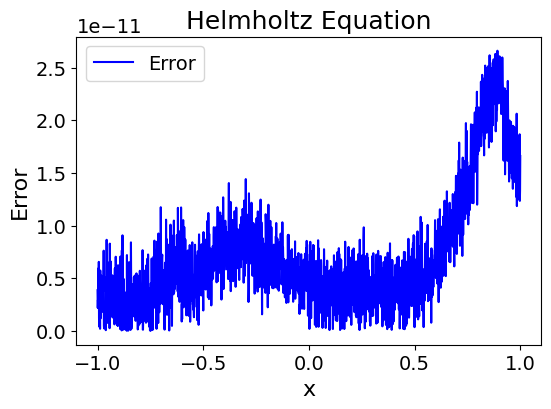

-----------------------------at step 191 ----------------------------------
the interior loss is 7.286527465192656
the error of least square in problem helmholtz1d:  3.722906162994827e-11
the condition number of matrix A in problem helmholtz1d:  1.278244105914091e+16
the rank of matrix A in problem helmholtz1d:  98
the maximum pointwise error in problem helmholtz1d:  2.1008084161167062e-11
the l2 relative error in problem helmholtz1d:  4.6786531185264125e-12


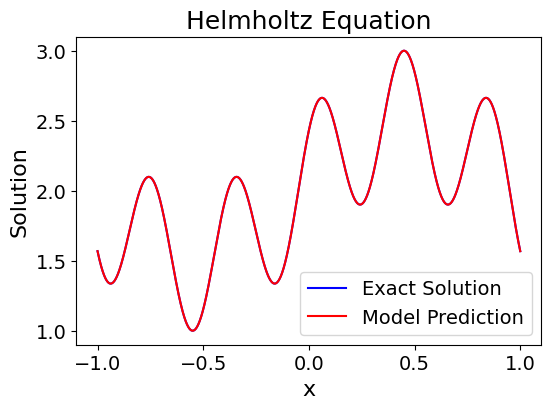

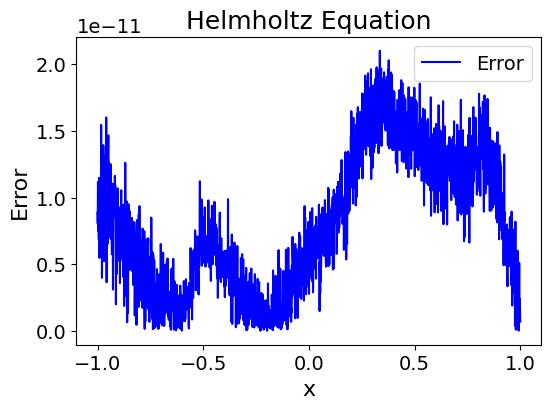

the error of least square in problem helmholtz1d:  2.510114519933207e-11
the condition number of matrix A in problem helmholtz1d:  1.5890482921899206e+16
the rank of matrix A in problem helmholtz1d:  100
the maximum pointwise error in problem helmholtz1d:  1.3041123736456939e-11
the l2 relative error in problem helmholtz1d:  2.505701741423851e-12


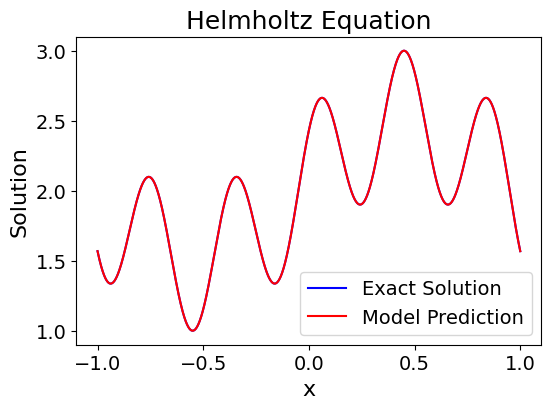

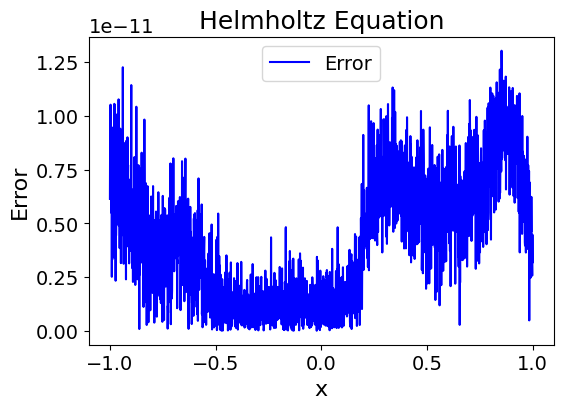

In [10]:
Pro = problem.Helmholtz(f, u_exact, u_exact, -1, 1)

params = {"radius": 1, "d": 1, "dd": 200, "bodyBatch": 1000, "bdryBatch":2, "lr": 0.001, "width": 200, "depth": 2, "trainStep": 200, "bdry_penalty": 1, "numberoftest": 3000, "writeStep": 200, "plotStep": 300, "lsStep": 10, "step_size": 5000, "milestone": [2000,6000,10000], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-4, "beta": 1, "orthogonalpenalty": 0}


startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])

startTime = time.time()
error_l2s, error_l2_rels, pde_losses = trainnew(model,Pro,device,params,optimizer,scheduler) 

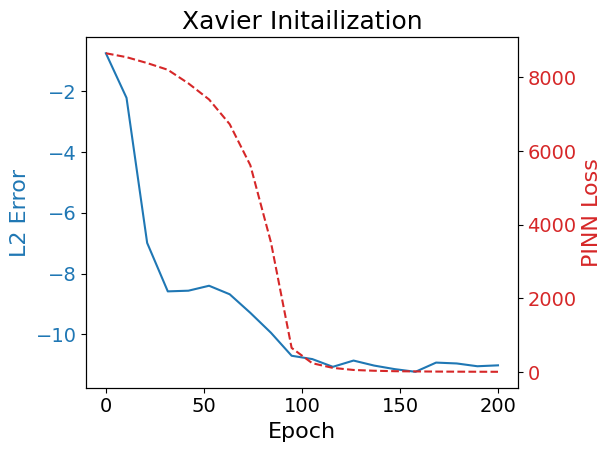

In [11]:


# 示例数据
x = np.linspace(0, 200, 20)
y1 = np.log10(error_l2s)
y2 = pde_losses

fig, ax1 = plt.subplots()

# L2 Error 曲线
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error', color=color)
ax1.plot(x, y1, color=color, label='L2 Error')
ax1.tick_params(axis='y', labelcolor=color)

# PINN Loss 曲线
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PINN Loss', color=color)
ax2.plot(x, y2, color=color, linestyle='--', label='PINN Loss')
ax2.tick_params(axis='y', labelcolor=color)

# 标题
plt.title("Xavier Initailization")
fig.tight_layout()
plt.show()


Initial pde loss is 8126.986435751955
Error at Step 1 is 8126.986435751955 with pde loss tensor(8126.9864, device='cuda:0', grad_fn=<AddBackward0>), orthogonal loss 73459.86095124409 and rank of matrix 22.
the maximum pointwise error in problem helmholtz1d:  2.7786307338768057
the l2 relative error in problem helmholtz1d:  0.9329685769697093


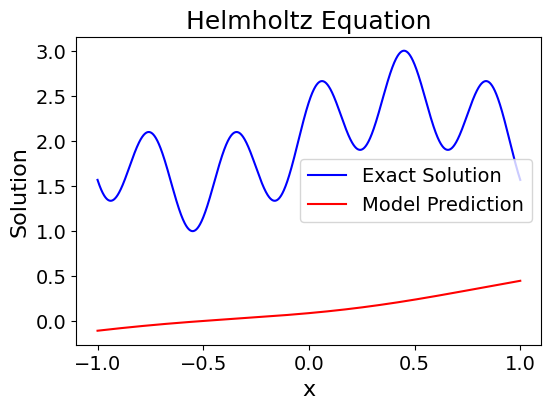

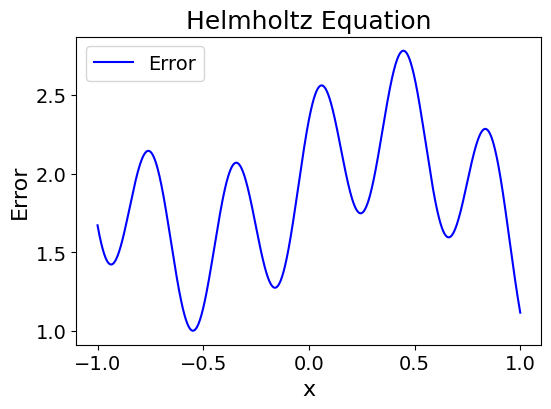

-----------------------------at step 1 ----------------------------------
the interior loss is 8126.986435751955
the error of least square in problem helmholtz1d:  6.999597179179096e-06
the condition number of matrix A in problem helmholtz1d:  1.261146927776349e+16
the rank of matrix A in problem helmholtz1d:  26
the maximum pointwise error in problem helmholtz1d:  1.5393141148400957e-06
the l2 relative error in problem helmholtz1d:  3.013807569249656e-07


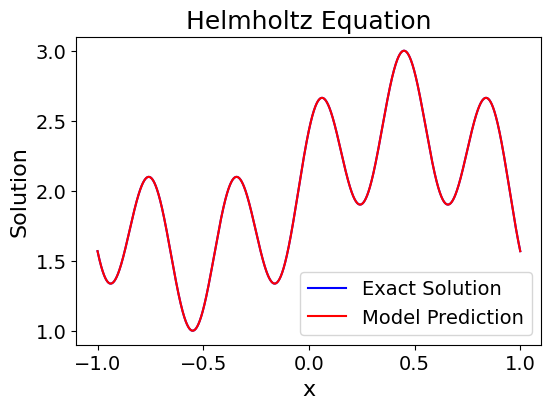

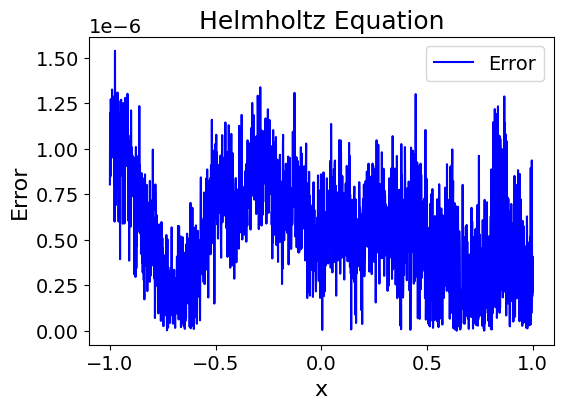

-----------------------------at step 11 ----------------------------------
the interior loss is 7720.964169383835
the error of least square in problem helmholtz1d:  1.9527947196651044e-08
the condition number of matrix A in problem helmholtz1d:  1.188513089741591e+16
the rank of matrix A in problem helmholtz1d:  35
the maximum pointwise error in problem helmholtz1d:  4.567961120471864e-09
the l2 relative error in problem helmholtz1d:  7.602020971368141e-10


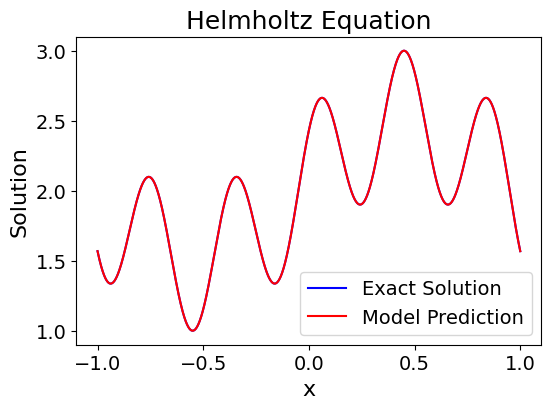

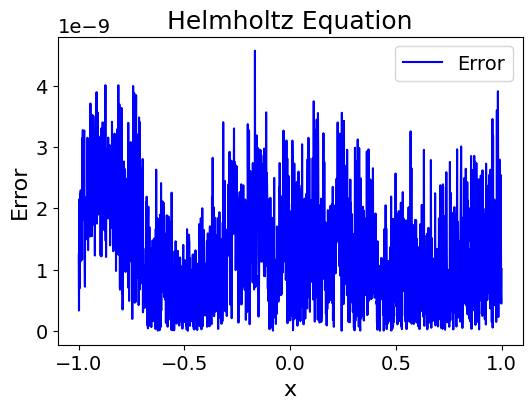

-----------------------------at step 21 ----------------------------------
the interior loss is 7646.744400945819
the error of least square in problem helmholtz1d:  6.208141174602155e-09
the condition number of matrix A in problem helmholtz1d:  9825777784203112.0
the rank of matrix A in problem helmholtz1d:  38
the maximum pointwise error in problem helmholtz1d:  2.5689015359375844e-09
the l2 relative error in problem helmholtz1d:  4.2744875888276826e-10


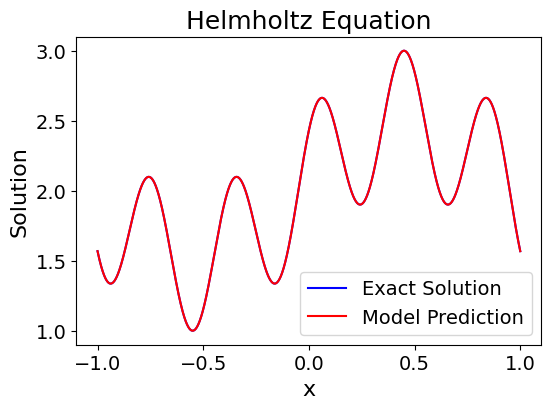

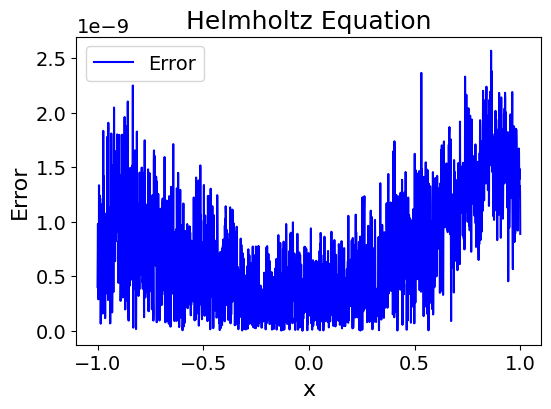

-----------------------------at step 31 ----------------------------------
the interior loss is 7488.988419415683
the error of least square in problem helmholtz1d:  1.8341860851346388e-10
the condition number of matrix A in problem helmholtz1d:  1.4053705887715294e+16
the rank of matrix A in problem helmholtz1d:  46
the maximum pointwise error in problem helmholtz1d:  1.6012258186037798e-10
the l2 relative error in problem helmholtz1d:  2.0736833442811458e-11


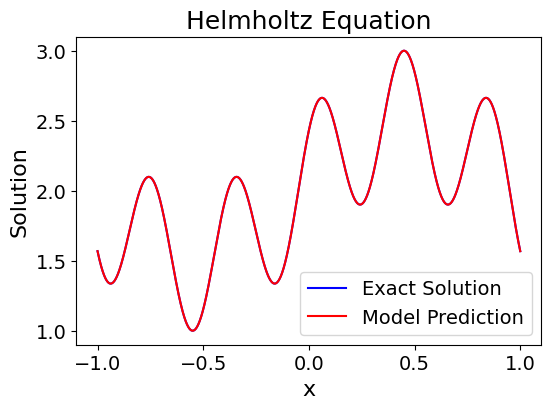

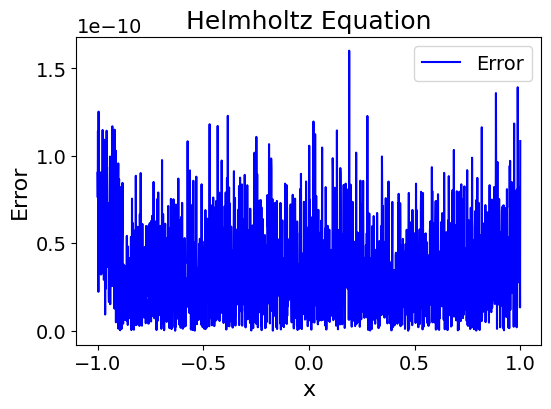

-----------------------------at step 41 ----------------------------------
the interior loss is 6736.961206674703
the error of least square in problem helmholtz1d:  3.075647883648429e-11
the condition number of matrix A in problem helmholtz1d:  1.8614277922920204e+16
the rank of matrix A in problem helmholtz1d:  63
the maximum pointwise error in problem helmholtz1d:  9.062084416200378e-12
the l2 relative error in problem helmholtz1d:  1.920954951412361e-12


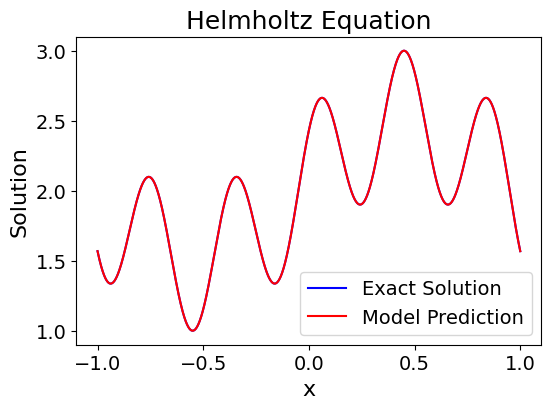

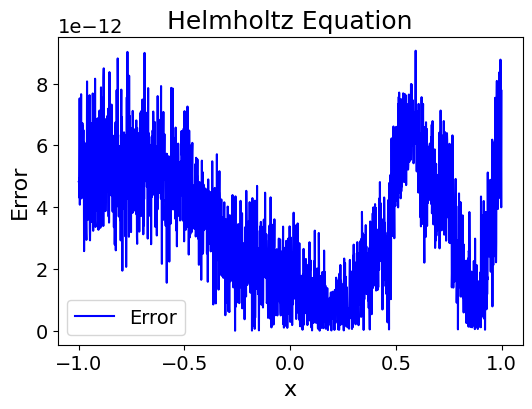

-----------------------------at step 51 ----------------------------------
the interior loss is 5087.1135300477235
the error of least square in problem helmholtz1d:  6.08737322542457e-13
the condition number of matrix A in problem helmholtz1d:  2.3352918584952436e+16
the rank of matrix A in problem helmholtz1d:  79
the maximum pointwise error in problem helmholtz1d:  7.926992395823618e-13
the l2 relative error in problem helmholtz1d:  9.957620797411718e-14


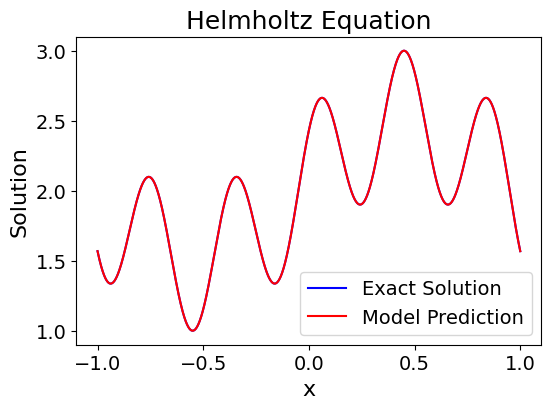

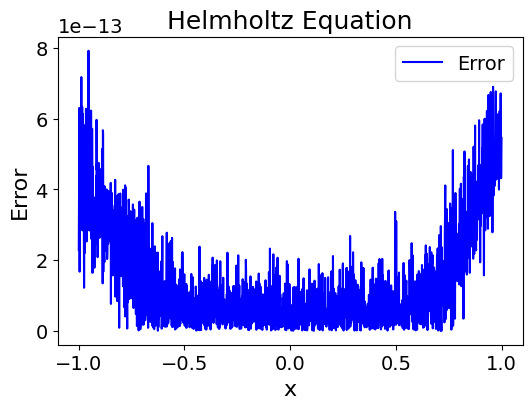

-----------------------------at step 61 ----------------------------------
the interior loss is 2391.624072556269
the error of least square in problem helmholtz1d:  6.692390082500213e-13
the condition number of matrix A in problem helmholtz1d:  2.213682504173597e+16
the rank of matrix A in problem helmholtz1d:  100
the maximum pointwise error in problem helmholtz1d:  5.024869409453459e-13
the l2 relative error in problem helmholtz1d:  1.4301591824551757e-13


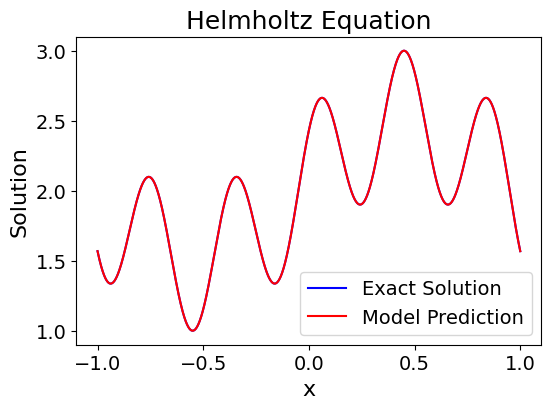

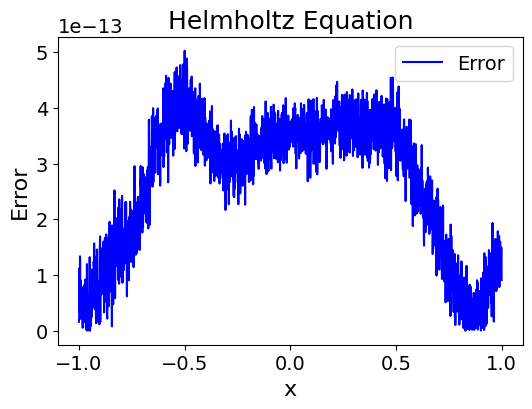

-----------------------------at step 71 ----------------------------------
the interior loss is 868.1640878042318
the error of least square in problem helmholtz1d:  3.277980075065532e-13
the condition number of matrix A in problem helmholtz1d:  2.0330869309874732e+16
the rank of matrix A in problem helmholtz1d:  119
the maximum pointwise error in problem helmholtz1d:  4.3165471197426086e-13
the l2 relative error in problem helmholtz1d:  7.674591276643158e-14


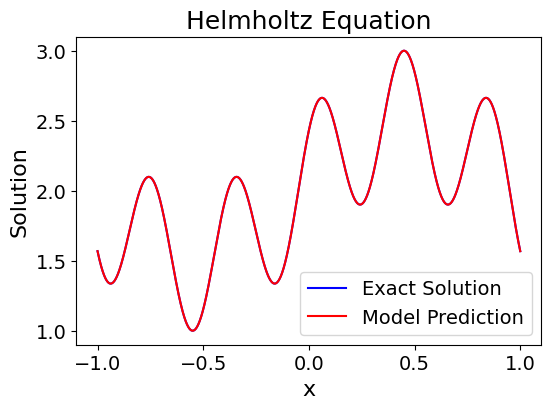

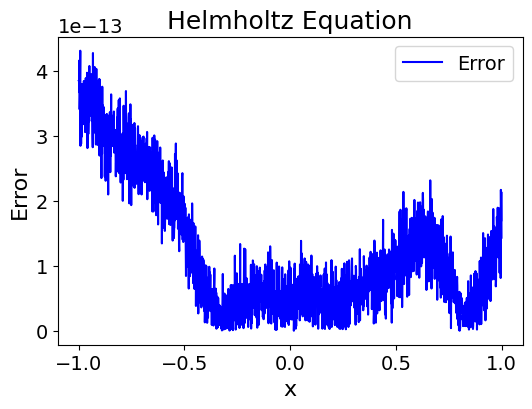

-----------------------------at step 81 ----------------------------------
the interior loss is 287.1844256608853
the error of least square in problem helmholtz1d:  4.37243115496258e-13
the condition number of matrix A in problem helmholtz1d:  1.938255629737672e+16
the rank of matrix A in problem helmholtz1d:  127
the maximum pointwise error in problem helmholtz1d:  2.957634137601417e-13
the l2 relative error in problem helmholtz1d:  4.767123079307694e-14


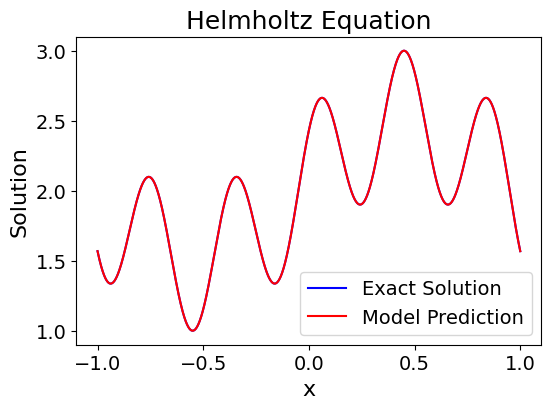

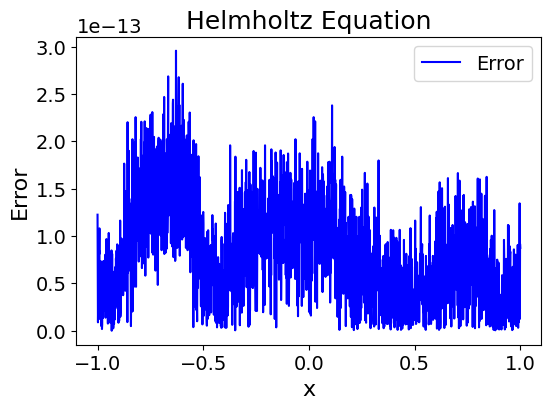

-----------------------------at step 91 ----------------------------------
the interior loss is 49.59327523607338
the error of least square in problem helmholtz1d:  3.4097399062594587e-13
the condition number of matrix A in problem helmholtz1d:  1.9332505499802096e+16
the rank of matrix A in problem helmholtz1d:  132
the maximum pointwise error in problem helmholtz1d:  2.993161274389422e-13
the l2 relative error in problem helmholtz1d:  4.037148514325009e-14


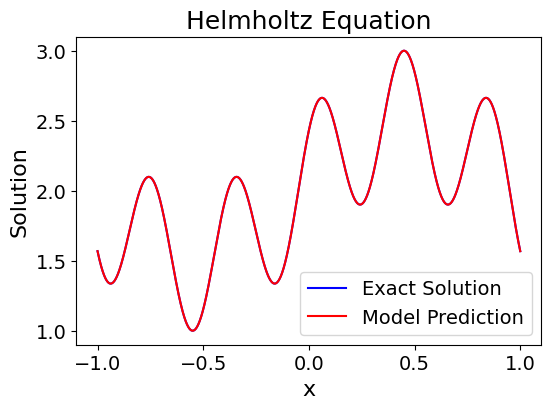

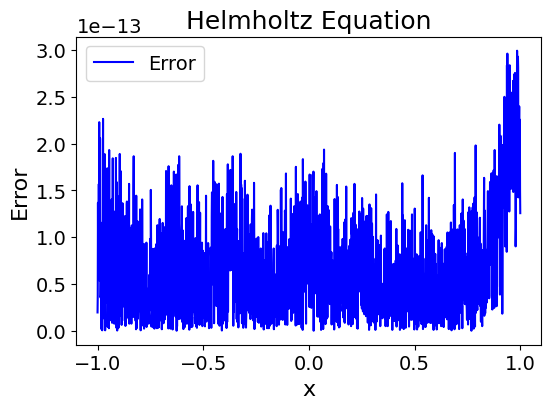

-----------------------------at step 101 ----------------------------------
the interior loss is 9.662400752561588
the error of least square in problem helmholtz1d:  1.433078598238799e-13
the condition number of matrix A in problem helmholtz1d:  2.1500020132405052e+16
the rank of matrix A in problem helmholtz1d:  134
the maximum pointwise error in problem helmholtz1d:  1.3278267374516872e-13
the l2 relative error in problem helmholtz1d:  1.830473195311899e-14


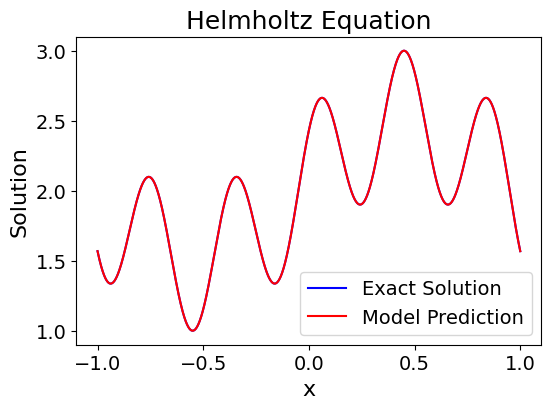

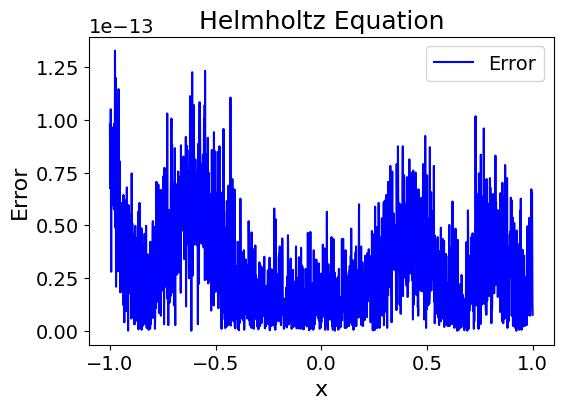

-----------------------------at step 111 ----------------------------------
the interior loss is 3.568989731212115
the error of least square in problem helmholtz1d:  1.0864226102165868e-13
the condition number of matrix A in problem helmholtz1d:  2.2765450013640804e+16
the rank of matrix A in problem helmholtz1d:  134
the maximum pointwise error in problem helmholtz1d:  1.361133428190442e-13
the l2 relative error in problem helmholtz1d:  1.8794708672333193e-14


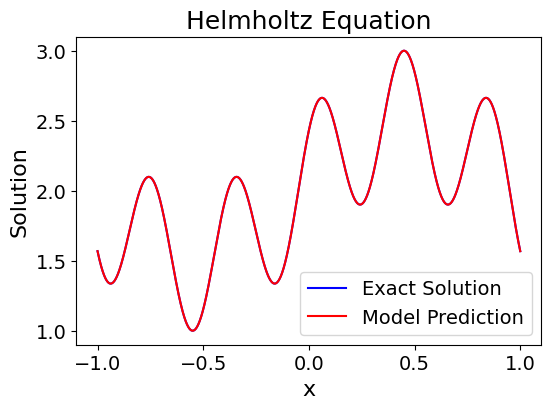

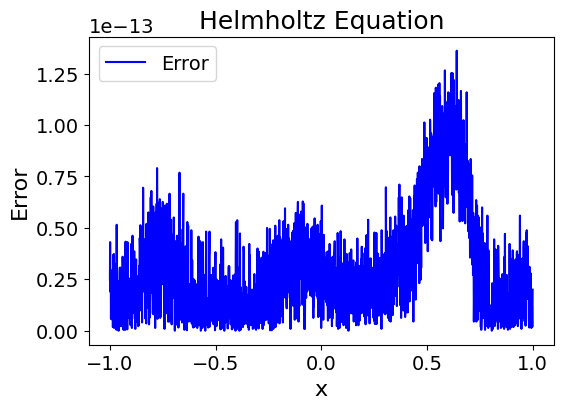

-----------------------------at step 121 ----------------------------------
the interior loss is 3.2881948532042498
the error of least square in problem helmholtz1d:  2.2646823906367785e-13
the condition number of matrix A in problem helmholtz1d:  2.1212600823689588e+16
the rank of matrix A in problem helmholtz1d:  134
the maximum pointwise error in problem helmholtz1d:  1.8962609260597674e-13
the l2 relative error in problem helmholtz1d:  3.411359912973893e-14


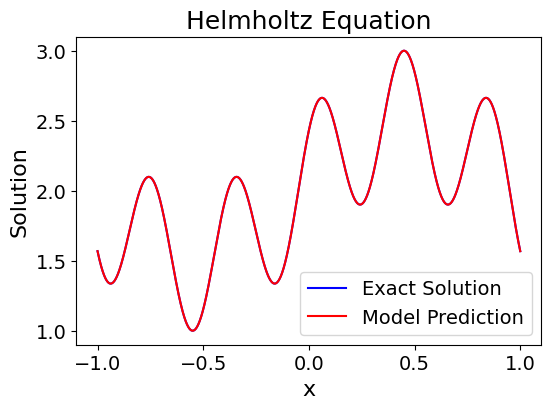

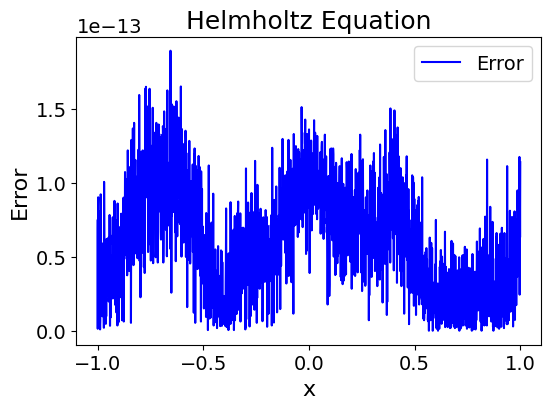

-----------------------------at step 131 ----------------------------------
the interior loss is 7.711605398932278
the error of least square in problem helmholtz1d:  1.255743127459275e-13
the condition number of matrix A in problem helmholtz1d:  1.8772513270626624e+16
the rank of matrix A in problem helmholtz1d:  136
the maximum pointwise error in problem helmholtz1d:  2.984279490192421e-13
the l2 relative error in problem helmholtz1d:  3.8370626430474176e-14


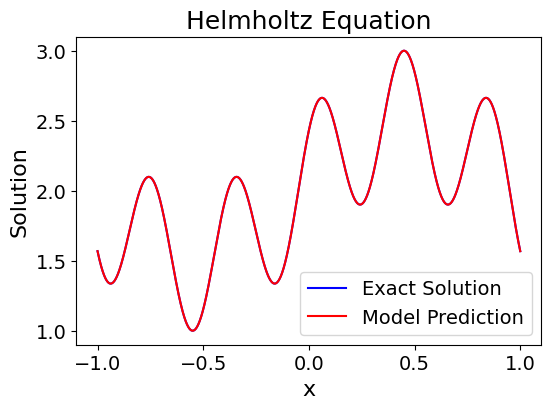

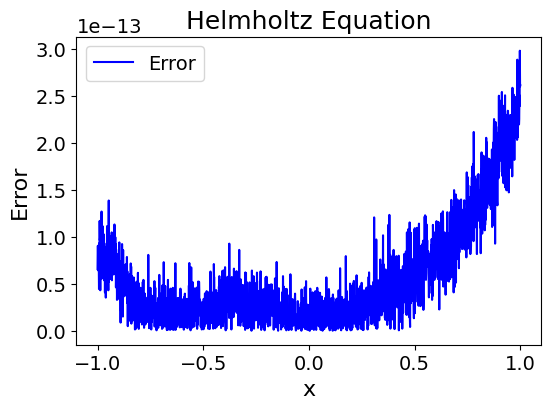

-----------------------------at step 141 ----------------------------------
the interior loss is 5.721244784087212
the error of least square in problem helmholtz1d:  1.2786934112484028e-13
the condition number of matrix A in problem helmholtz1d:  1.6630829871279512e+16
the rank of matrix A in problem helmholtz1d:  136
the maximum pointwise error in problem helmholtz1d:  2.864375403532904e-13
the l2 relative error in problem helmholtz1d:  4.57722256181106e-14


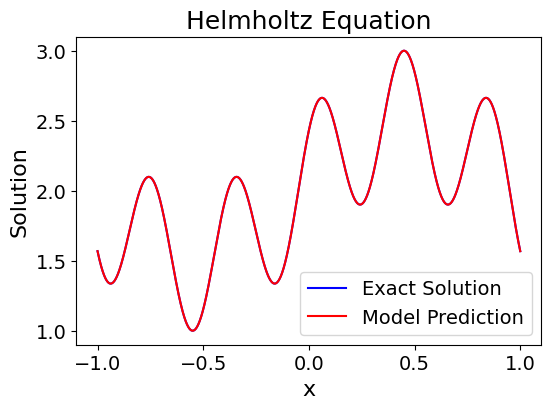

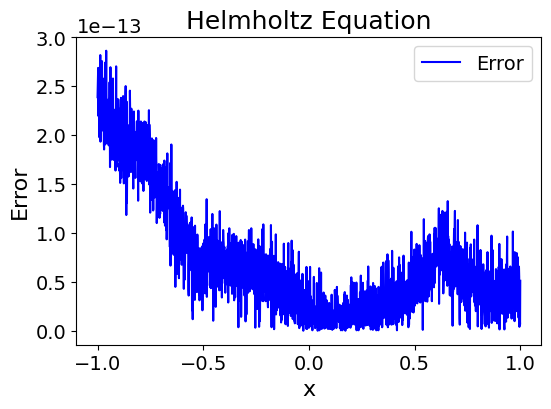

-----------------------------at step 151 ----------------------------------
the interior loss is 1.3376609827356951
the error of least square in problem helmholtz1d:  9.123528676276309e-14
the condition number of matrix A in problem helmholtz1d:  1.86940967008061e+16
the rank of matrix A in problem helmholtz1d:  136
the maximum pointwise error in problem helmholtz1d:  2.831068712794149e-13
the l2 relative error in problem helmholtz1d:  4.433317569361597e-14


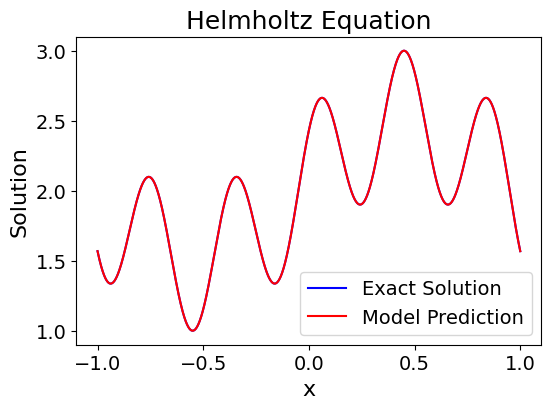

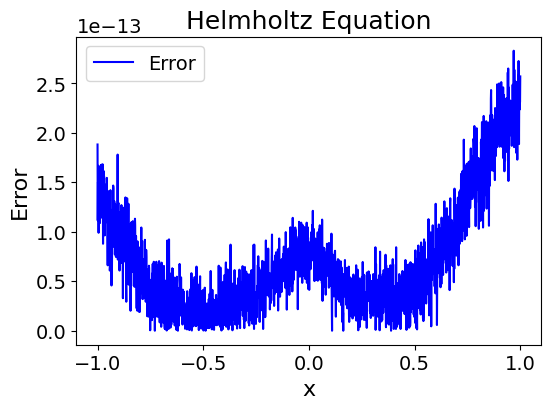

-----------------------------at step 161 ----------------------------------
the interior loss is 0.8995656149393367
the error of least square in problem helmholtz1d:  1.4637516005416553e-13
the condition number of matrix A in problem helmholtz1d:  1.8070390315081104e+16
the rank of matrix A in problem helmholtz1d:  136
the maximum pointwise error in problem helmholtz1d:  1.5276668818842154e-13
the l2 relative error in problem helmholtz1d:  2.98722077379744e-14


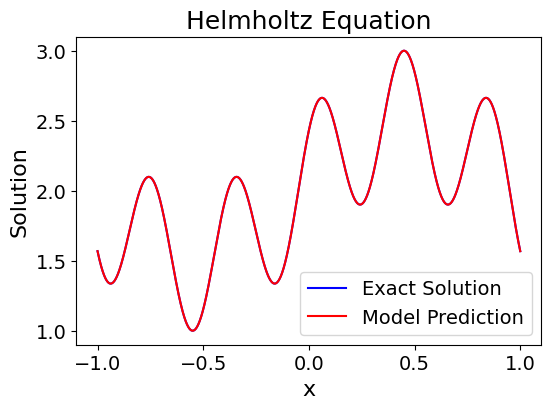

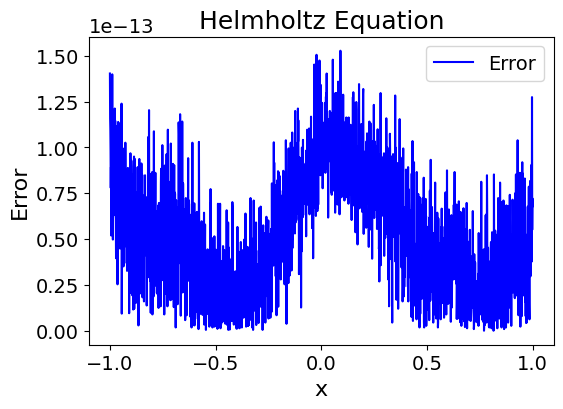

-----------------------------at step 171 ----------------------------------
the interior loss is 0.8787154302989977
the error of least square in problem helmholtz1d:  7.862778130853971e-14
the condition number of matrix A in problem helmholtz1d:  1.4921521175793958e+16
the rank of matrix A in problem helmholtz1d:  136
the maximum pointwise error in problem helmholtz1d:  2.2515322939398175e-13
the l2 relative error in problem helmholtz1d:  3.2871827843542536e-14


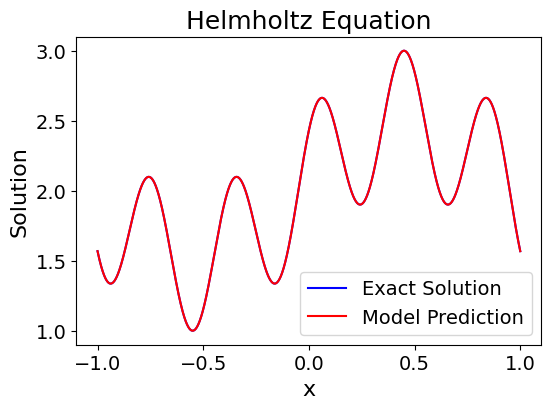

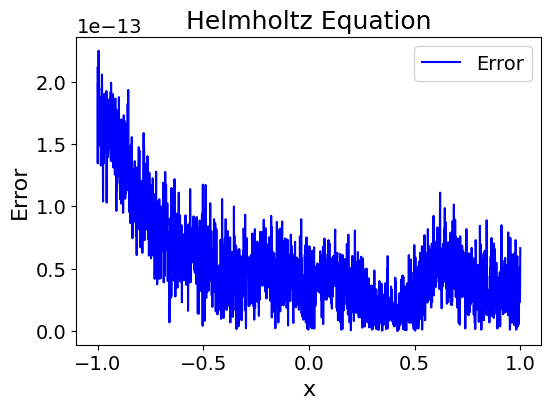

-----------------------------at step 181 ----------------------------------
the interior loss is 0.675741750149025
the error of least square in problem helmholtz1d:  1.2357277649521974e-13
the condition number of matrix A in problem helmholtz1d:  1.6315313470067108e+16
the rank of matrix A in problem helmholtz1d:  135
the maximum pointwise error in problem helmholtz1d:  2.1316282072803006e-13
the l2 relative error in problem helmholtz1d:  4.66705655722321e-14


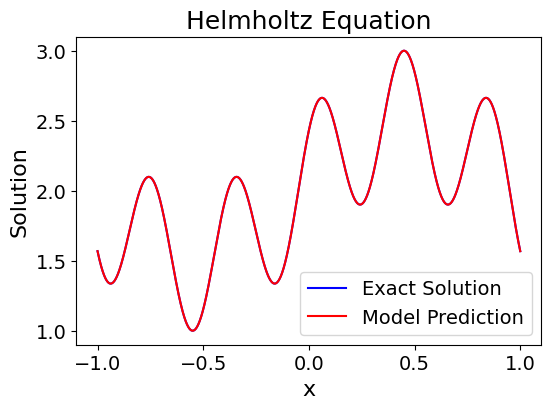

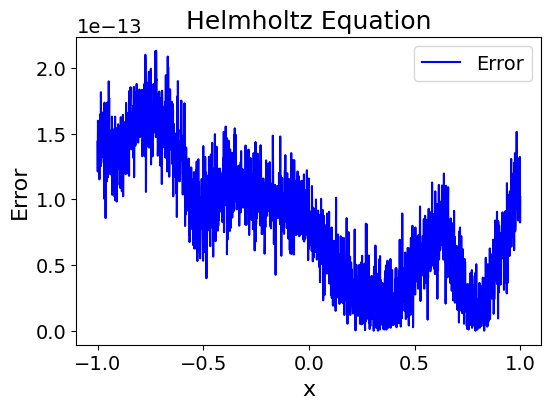

-----------------------------at step 191 ----------------------------------
the interior loss is 0.5544706134306021
the error of least square in problem helmholtz1d:  8.73227122082156e-14
the condition number of matrix A in problem helmholtz1d:  1.6387563287088518e+16
the rank of matrix A in problem helmholtz1d:  135
the maximum pointwise error in problem helmholtz1d:  1.7763568394002505e-13
the l2 relative error in problem helmholtz1d:  3.584678561545086e-14


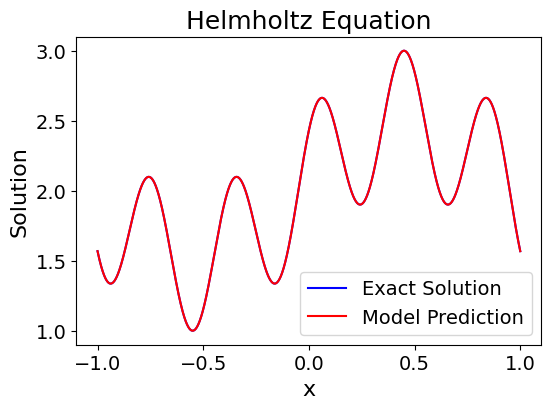

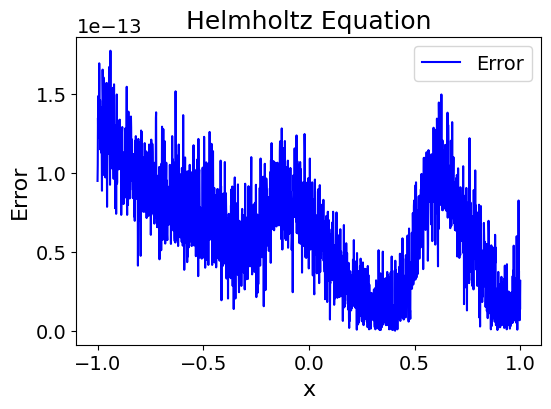

the error of least square in problem helmholtz1d:  9.446383245893854e-14
the condition number of matrix A in problem helmholtz1d:  1.6200571143907706e+16
the rank of matrix A in problem helmholtz1d:  135
the maximum pointwise error in problem helmholtz1d:  2.446931546273845e-13
the l2 relative error in problem helmholtz1d:  4.748329354604005e-14


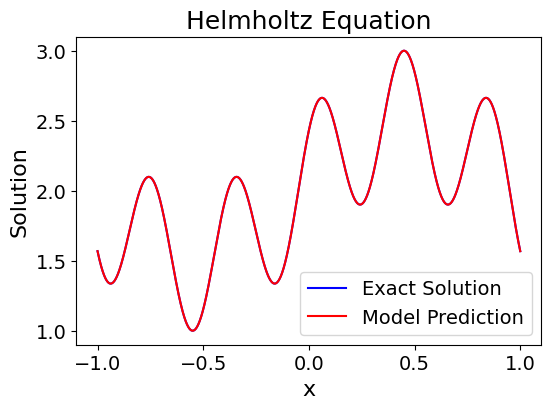

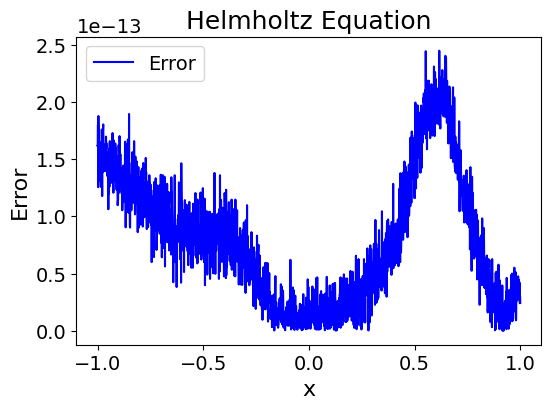

In [13]:
Pro = problem.Helmholtz(f, u_exact, u_exact, -1, 1)

params = {"radius": 1, "d": 1, "dd": 200, "bodyBatch": 1000, "bdryBatch":2, "lr": 0.001, "width": 200, "depth": 2, "trainStep": 200, "bdry_penalty": 1, "numberoftest": 3000, "writeStep": 200, "plotStep": 300, "lsStep": 10, "step_size": 5000, "milestone": [2000,6000,10000], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-8, "beta": 1, "orthogonalpenalty": 0}


startTime = time.time()
model = net.PD_OFM(params, initialization="kaiming").to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])

startTime = time.time()
error_l2s, error_l2_rels, interior_losses = trainnew(model,Pro,device,params,optimizer,scheduler) 

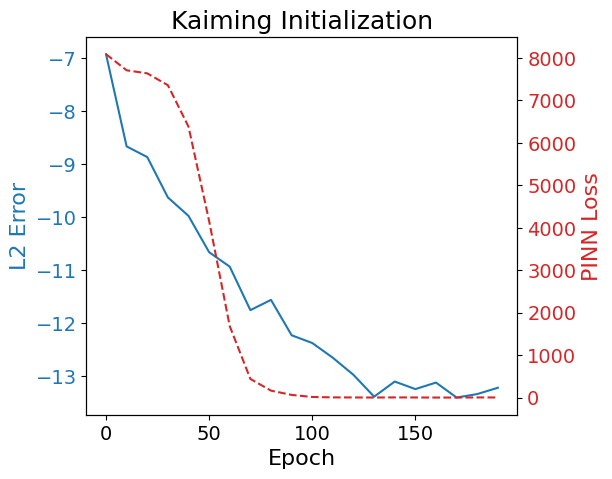

In [ ]:
x = np.array(range(len(error_l2s)))*10
y1 = np.log10(error_l2s)
y2 = interior_losses
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error', color=color)
ax1.plot(x, y1, color=color, label='L2 Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 共享 x 轴
color = 'tab:red'
ax2.set_ylabel('PINN Loss', color=color)
ax2.plot(x, y2, color=color, linestyle='--', label='PINN Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Kaiming Initialization")
plt.show()

Initial pde loss is 8535.776621011424
Error at Step 1 is 8535.776621011424 with pde loss tensor(8535.7766, device='cuda:0', grad_fn=<AddBackward0>), orthogonal loss 689.2256175418978 and rank of matrix 11.
the maximum pointwise error in problem helmholtz1d:  3.071974572360627
the l2 relative error in problem helmholtz1d:  1.0247802369007706


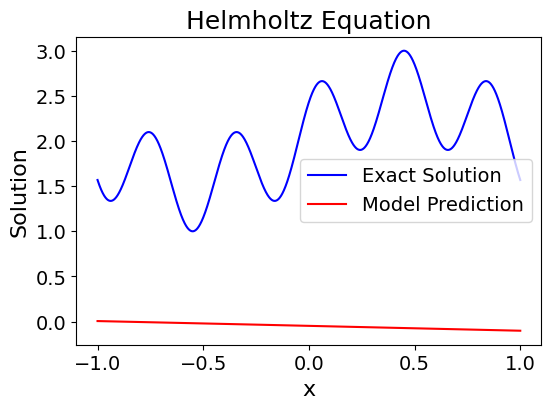

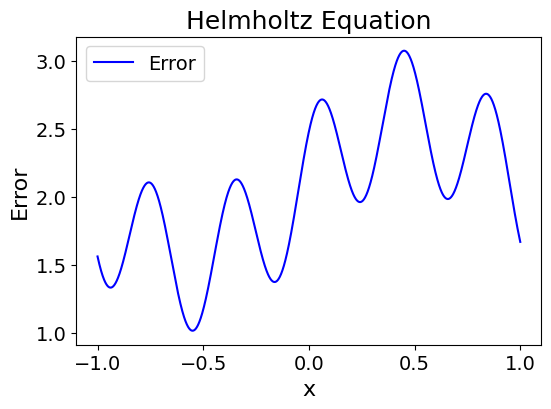

-----------------------------at step 1 ----------------------------------
the interior loss is 8535.776621011424
the error of least square in problem helmholtz1d:  52.71847794580246
the condition number of matrix A in problem helmholtz1d:  6.8056026047935976e+16
the rank of matrix A in problem helmholtz1d:  12
the maximum pointwise error in problem helmholtz1d:  0.909181341070731
the l2 relative error in problem helmholtz1d:  0.18536088832664957


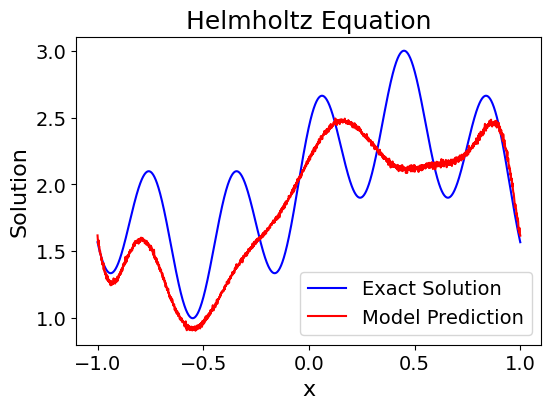

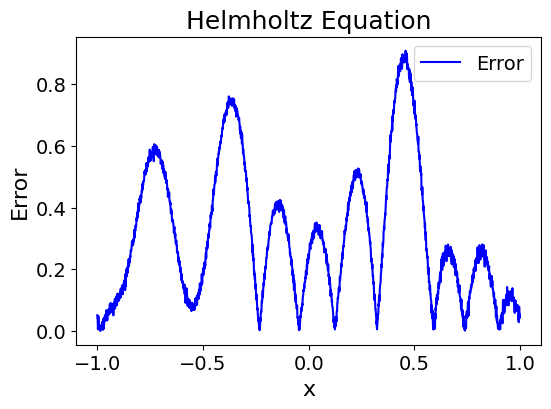

-----------------------------at step 11 ----------------------------------
the interior loss is 8419.483497113368
the error of least square in problem helmholtz1d:  30.035371934714032
the condition number of matrix A in problem helmholtz1d:  7.829448313998515e+16
the rank of matrix A in problem helmholtz1d:  14
the maximum pointwise error in problem helmholtz1d:  0.42728560668053994
the l2 relative error in problem helmholtz1d:  0.08893618821283998


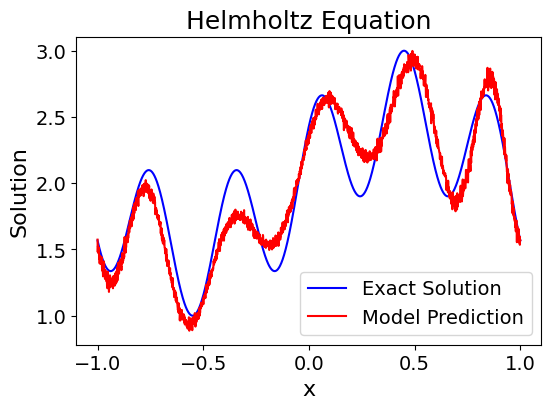

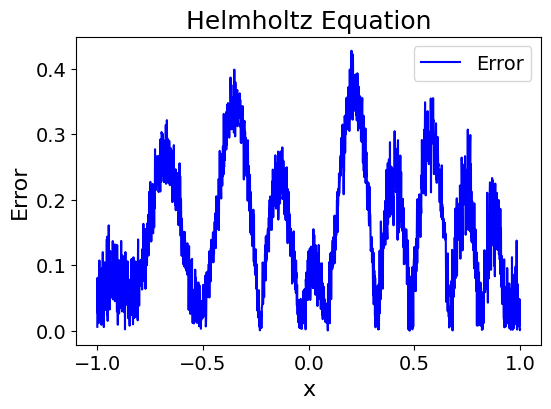

-----------------------------at step 21 ----------------------------------
the interior loss is 8240.001817757693
the error of least square in problem helmholtz1d:  4.521309817769573
the condition number of matrix A in problem helmholtz1d:  4.8720847465216824e+16
the rank of matrix A in problem helmholtz1d:  16
the maximum pointwise error in problem helmholtz1d:  0.6281601347814869
the l2 relative error in problem helmholtz1d:  0.09502028668600027


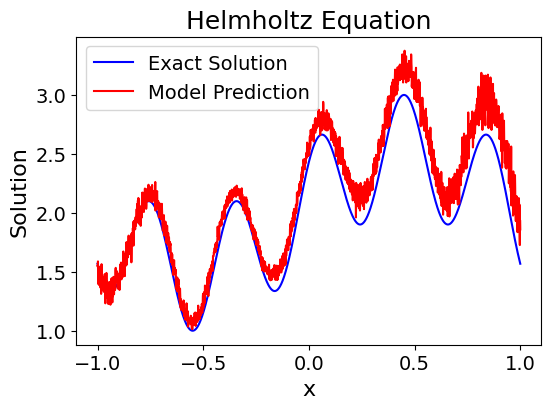

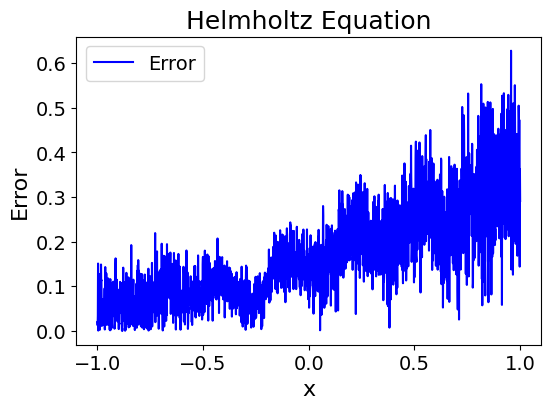

-----------------------------at step 31 ----------------------------------
the interior loss is 7957.271406471035
the error of least square in problem helmholtz1d:  0.04294958568196228
the condition number of matrix A in problem helmholtz1d:  3.1344187514959692e+16
the rank of matrix A in problem helmholtz1d:  19
the maximum pointwise error in problem helmholtz1d:  0.04824547736361007
the l2 relative error in problem helmholtz1d:  0.00447219702049758


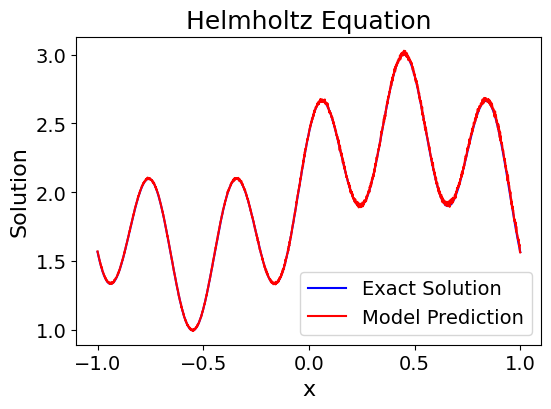

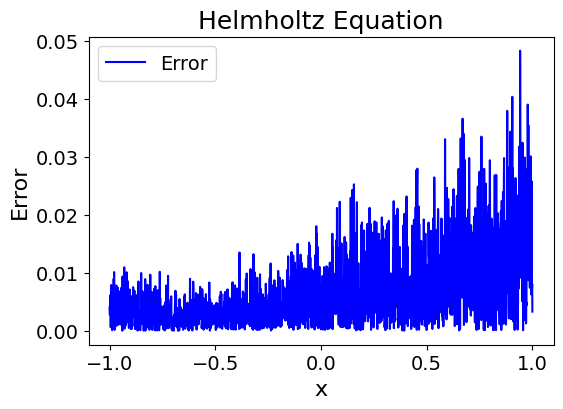

-----------------------------at step 41 ----------------------------------
the interior loss is 7928.458714414067
the error of least square in problem helmholtz1d:  0.0007925565184335329
the condition number of matrix A in problem helmholtz1d:  1.7145554230102218e+16
the rank of matrix A in problem helmholtz1d:  22
the maximum pointwise error in problem helmholtz1d:  0.00021225090538035118
the l2 relative error in problem helmholtz1d:  3.1037300393941886e-05


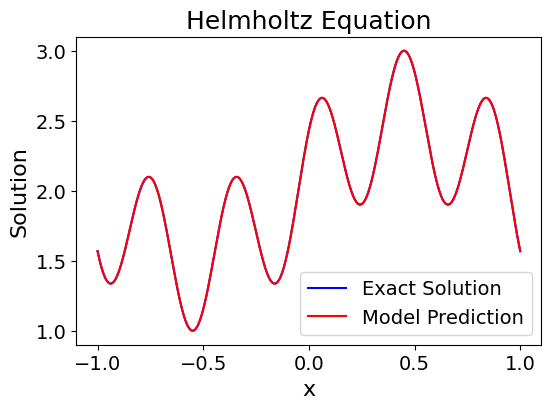

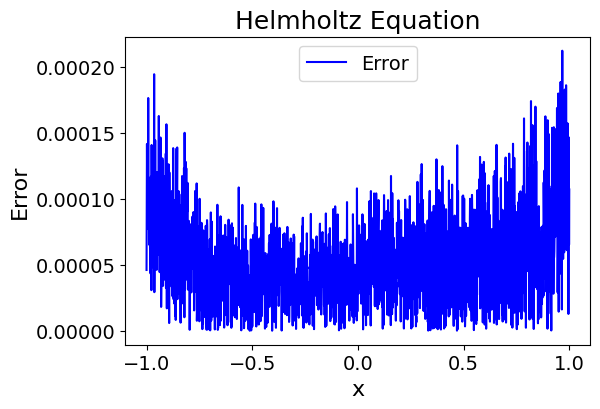

-----------------------------at step 51 ----------------------------------
the interior loss is 7900.691453160208
the error of least square in problem helmholtz1d:  2.5421620667916703e-06
the condition number of matrix A in problem helmholtz1d:  9522646155388932.0
the rank of matrix A in problem helmholtz1d:  27
the maximum pointwise error in problem helmholtz1d:  1.7315082883051502e-06
the l2 relative error in problem helmholtz1d:  1.5554682786561525e-07


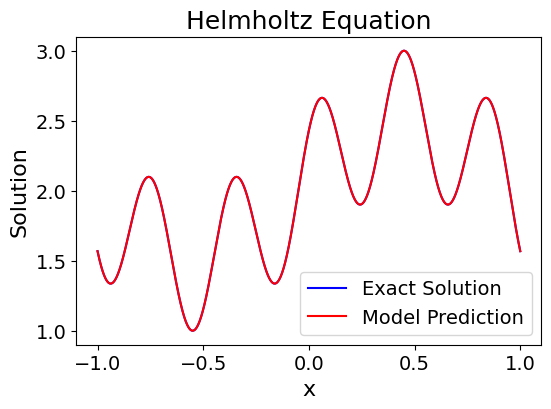

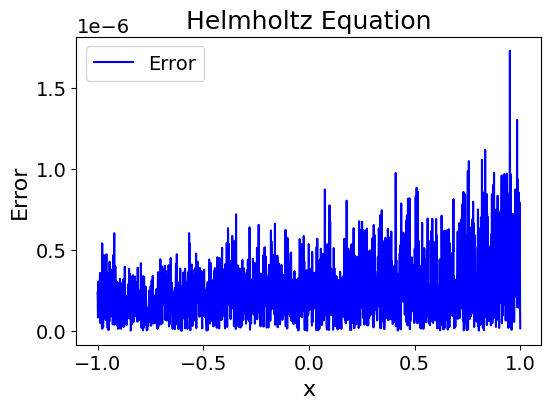

-----------------------------at step 61 ----------------------------------
the interior loss is 7891.519472003175
the error of least square in problem helmholtz1d:  2.502284421130589e-07
the condition number of matrix A in problem helmholtz1d:  1.3207858698516922e+16
the rank of matrix A in problem helmholtz1d:  30
the maximum pointwise error in problem helmholtz1d:  8.990697386579427e-08
the l2 relative error in problem helmholtz1d:  1.491515461255347e-08


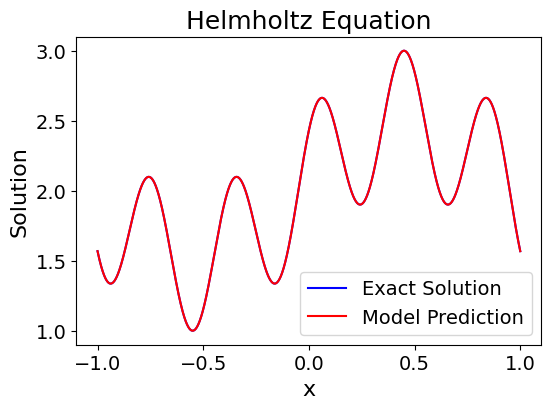

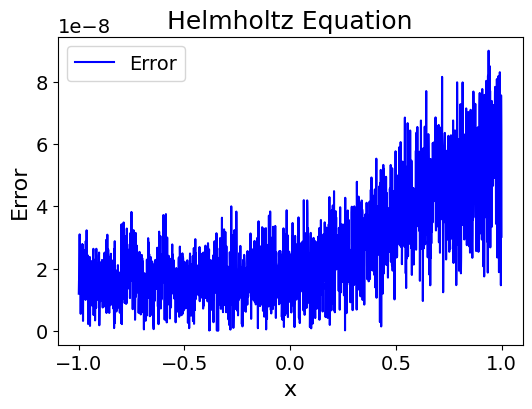

-----------------------------at step 71 ----------------------------------
the interior loss is 7882.732225922934
the error of least square in problem helmholtz1d:  9.380286075274475e-08
the condition number of matrix A in problem helmholtz1d:  9169379621310478.0
the rank of matrix A in problem helmholtz1d:  32
the maximum pointwise error in problem helmholtz1d:  8.69392291491522e-09
the l2 relative error in problem helmholtz1d:  1.2721615110789078e-09


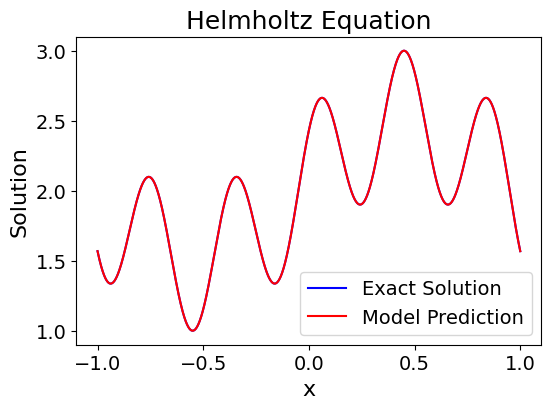

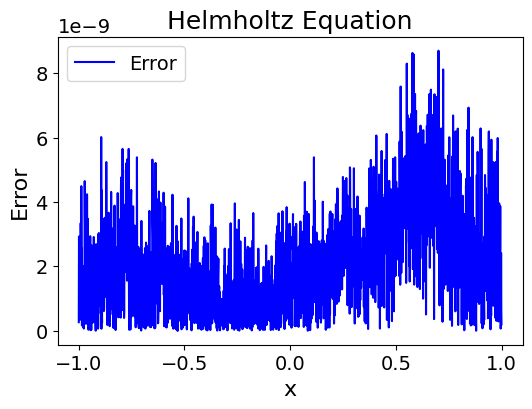

-----------------------------at step 81 ----------------------------------
the interior loss is 7865.583011707384
the error of least square in problem helmholtz1d:  1.071598316214575e-08
the condition number of matrix A in problem helmholtz1d:  1.1367565633595952e+16
the rank of matrix A in problem helmholtz1d:  34
the maximum pointwise error in problem helmholtz1d:  2.1478774314687143e-09
the l2 relative error in problem helmholtz1d:  2.898753369025073e-10


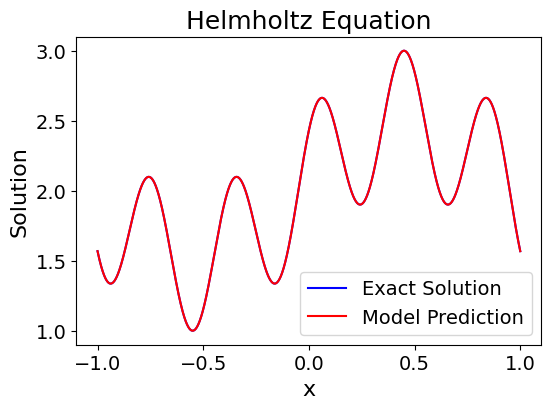

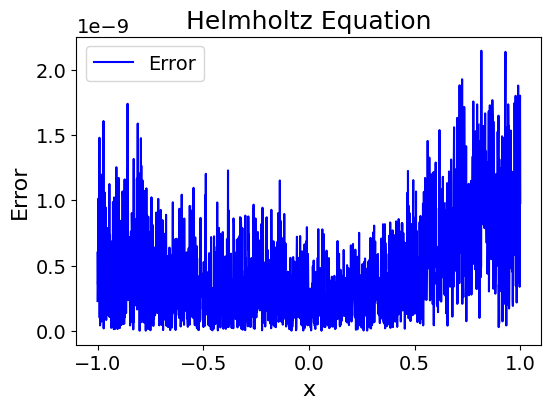

-----------------------------at step 91 ----------------------------------
the interior loss is 7811.2742591177475
the error of least square in problem helmholtz1d:  6.928615905145771e-09
the condition number of matrix A in problem helmholtz1d:  1.0559258552524536e+16
the rank of matrix A in problem helmholtz1d:  40
the maximum pointwise error in problem helmholtz1d:  7.292684234272429e-10
the l2 relative error in problem helmholtz1d:  1.3359120588593514e-10


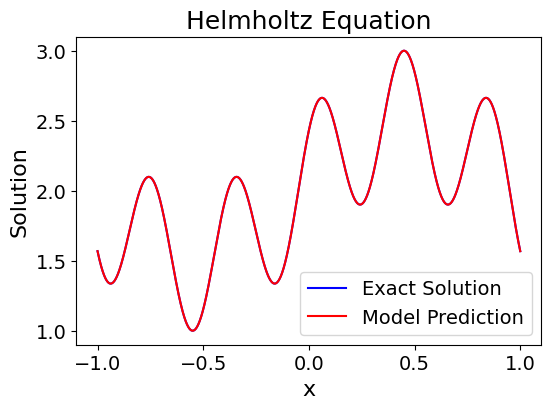

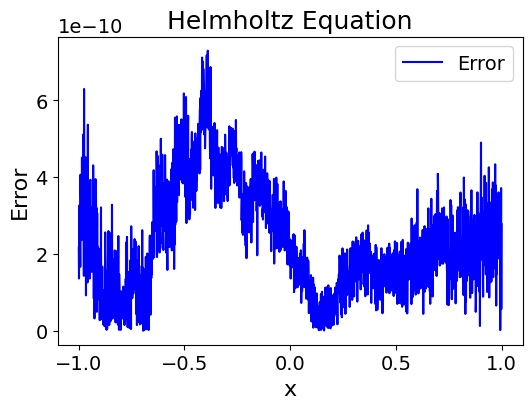

-----------------------------at step 101 ----------------------------------
the interior loss is 7159.136066766534
the error of least square in problem helmholtz1d:  2.7063177343677823e-10
the condition number of matrix A in problem helmholtz1d:  1.4011100110730224e+16
the rank of matrix A in problem helmholtz1d:  53
the maximum pointwise error in problem helmholtz1d:  4.888578430950474e-11
the l2 relative error in problem helmholtz1d:  9.040532234788548e-12


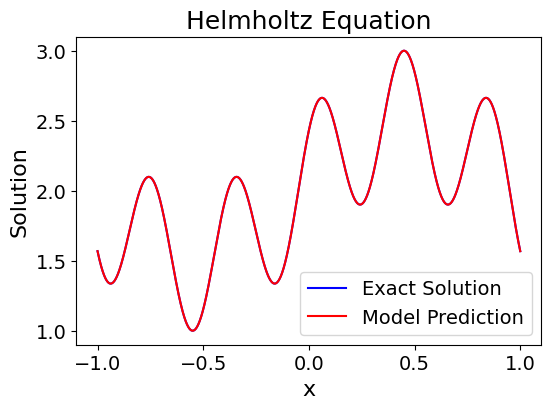

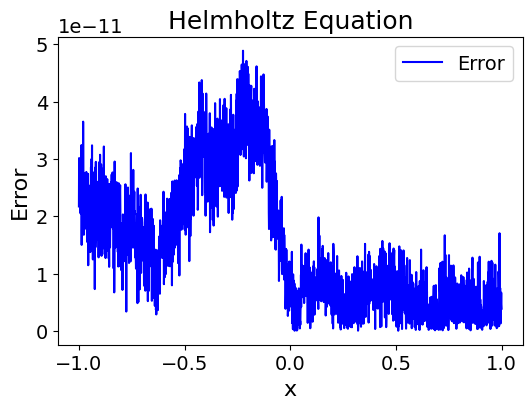

-----------------------------at step 111 ----------------------------------
the interior loss is 5247.771954472596
the error of least square in problem helmholtz1d:  2.712235598703411e-11
the condition number of matrix A in problem helmholtz1d:  1.210053332865912e+16
the rank of matrix A in problem helmholtz1d:  70
the maximum pointwise error in problem helmholtz1d:  1.1876721828230075e-11
the l2 relative error in problem helmholtz1d:  2.1453618648146512e-12


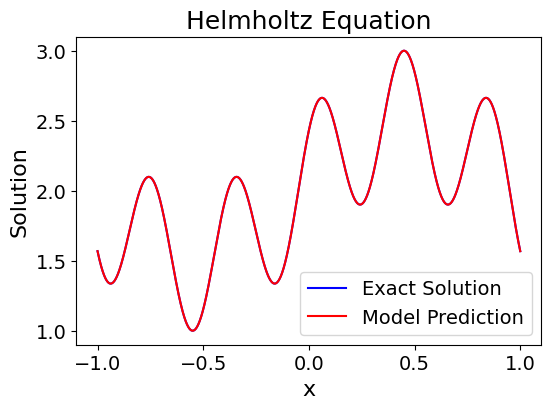

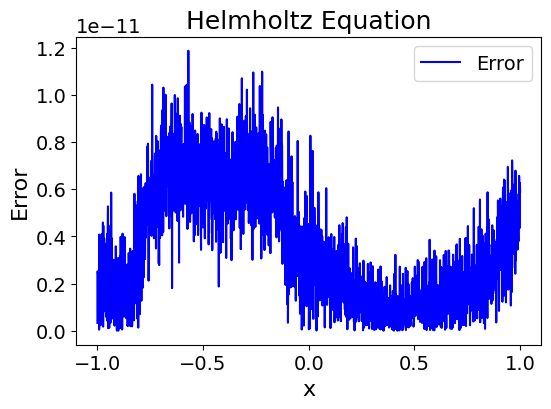

-----------------------------at step 121 ----------------------------------
the interior loss is 3675.211457725864
the error of least square in problem helmholtz1d:  1.1300278701797685e-11
the condition number of matrix A in problem helmholtz1d:  1.7592563799683738e+16
the rank of matrix A in problem helmholtz1d:  80
the maximum pointwise error in problem helmholtz1d:  9.679812507101815e-12
the l2 relative error in problem helmholtz1d:  1.223864064522112e-12


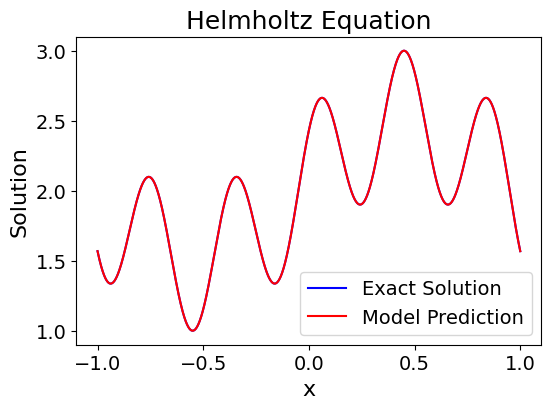

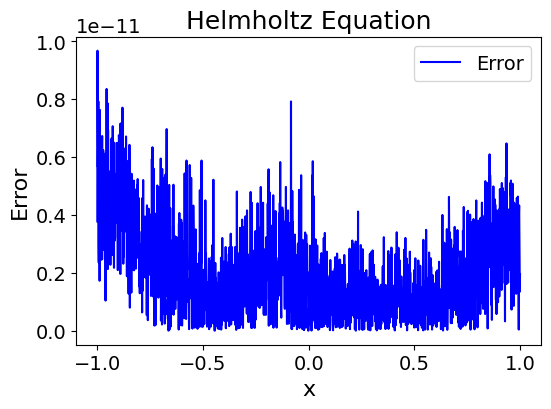

-----------------------------at step 131 ----------------------------------
the interior loss is 2218.060837698135
the error of least square in problem helmholtz1d:  3.0749987552931556e-12
the condition number of matrix A in problem helmholtz1d:  1.95602628644096e+16
the rank of matrix A in problem helmholtz1d:  89
the maximum pointwise error in problem helmholtz1d:  3.071987109137808e-12
the l2 relative error in problem helmholtz1d:  6.506906541549212e-13


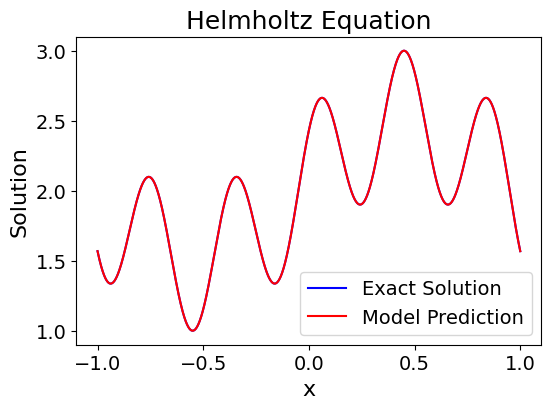

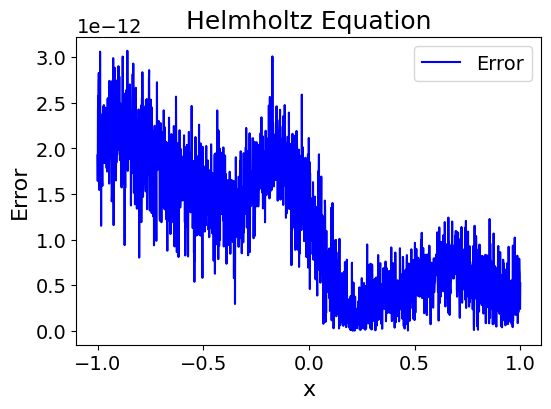

-----------------------------at step 141 ----------------------------------
the interior loss is 931.5705587728406
the error of least square in problem helmholtz1d:  3.40514745960409e-12
the condition number of matrix A in problem helmholtz1d:  1.5791934086182536e+16
the rank of matrix A in problem helmholtz1d:  98
the maximum pointwise error in problem helmholtz1d:  2.666311615939776e-12
the l2 relative error in problem helmholtz1d:  4.727482775829749e-13


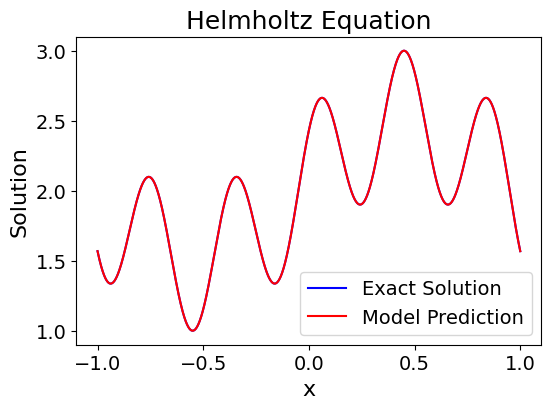

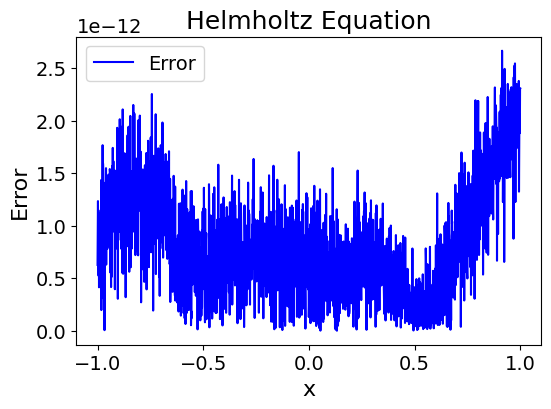

-----------------------------at step 151 ----------------------------------
the interior loss is 321.50533932515236
the error of least square in problem helmholtz1d:  2.8000014773499203e-13
the condition number of matrix A in problem helmholtz1d:  1.7723664456001166e+16
the rank of matrix A in problem helmholtz1d:  104
the maximum pointwise error in problem helmholtz1d:  7.784883848671598e-13
the l2 relative error in problem helmholtz1d:  1.2921270075549214e-13


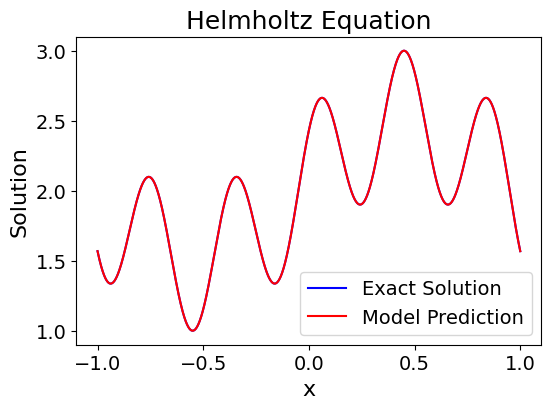

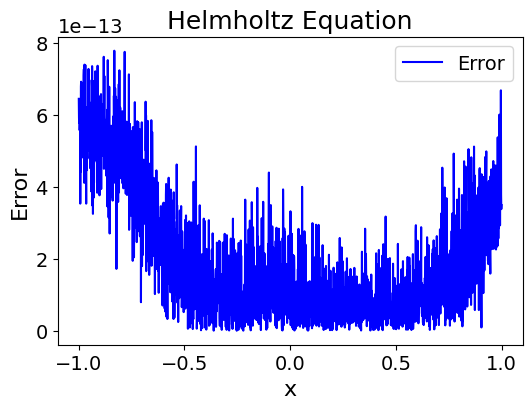

-----------------------------at step 161 ----------------------------------
the interior loss is 84.00451081233841
the error of least square in problem helmholtz1d:  5.475059998408288e-13
the condition number of matrix A in problem helmholtz1d:  2.0304637253510336e+16
the rank of matrix A in problem helmholtz1d:  106
the maximum pointwise error in problem helmholtz1d:  4.831690603168681e-13
the l2 relative error in problem helmholtz1d:  9.257947655423212e-14


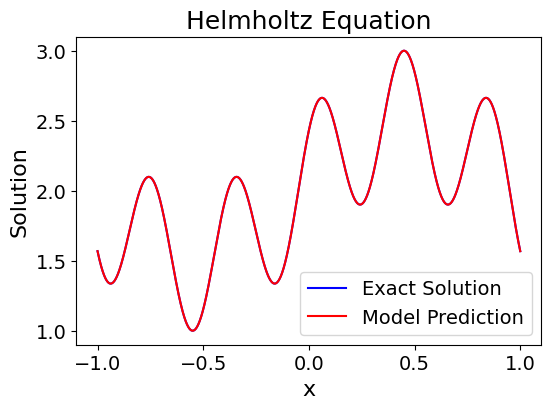

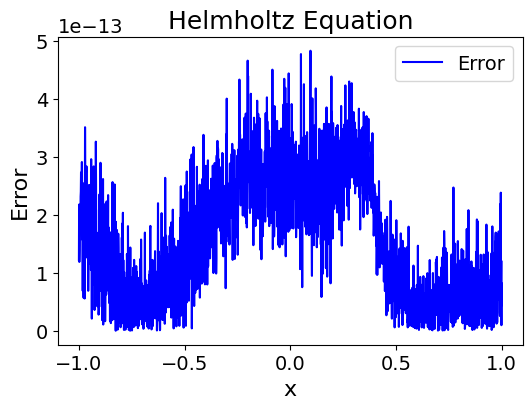

-----------------------------at step 171 ----------------------------------
the interior loss is 36.55745052130244
the error of least square in problem helmholtz1d:  2.163853206174953e-13
the condition number of matrix A in problem helmholtz1d:  1.857528671218044e+16
the rank of matrix A in problem helmholtz1d:  107
the maximum pointwise error in problem helmholtz1d:  4.3520742565306136e-13
the l2 relative error in problem helmholtz1d:  8.091371174366356e-14


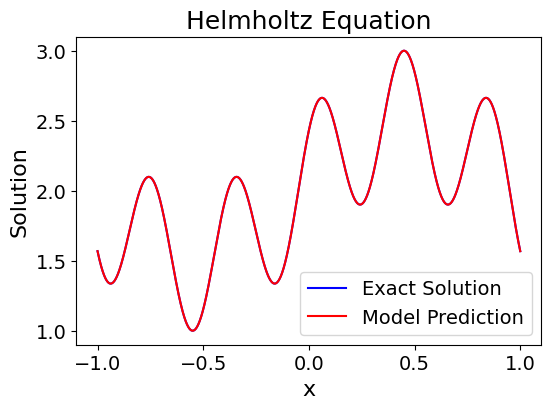

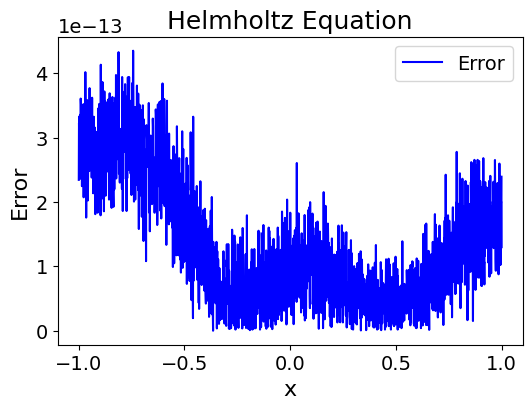

-----------------------------at step 181 ----------------------------------
the interior loss is 18.31343114586091
the error of least square in problem helmholtz1d:  3.934780187969301e-13
the condition number of matrix A in problem helmholtz1d:  2.1836986453145892e+16
the rank of matrix A in problem helmholtz1d:  106
the maximum pointwise error in problem helmholtz1d:  4.3787196091216174e-13
the l2 relative error in problem helmholtz1d:  7.781642336258366e-14


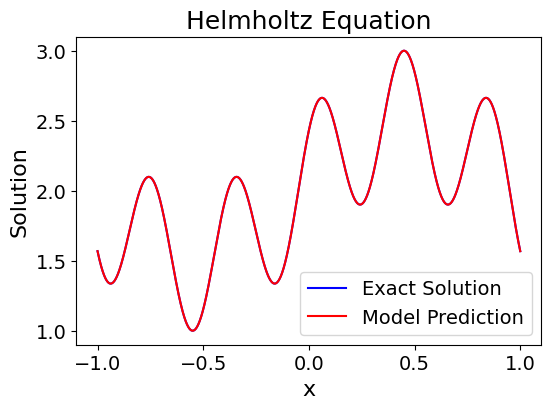

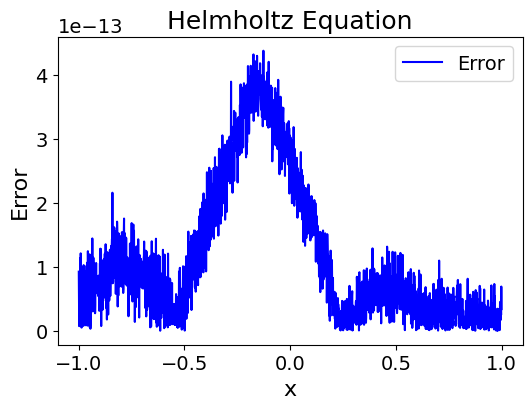

-----------------------------at step 191 ----------------------------------
the interior loss is 18.91564157801693
the error of least square in problem helmholtz1d:  2.6074837011226256e-13
the condition number of matrix A in problem helmholtz1d:  2.7640096495606628e+16
the rank of matrix A in problem helmholtz1d:  107
the maximum pointwise error in problem helmholtz1d:  6.761258219967203e-13
the l2 relative error in problem helmholtz1d:  7.843002287049283e-14


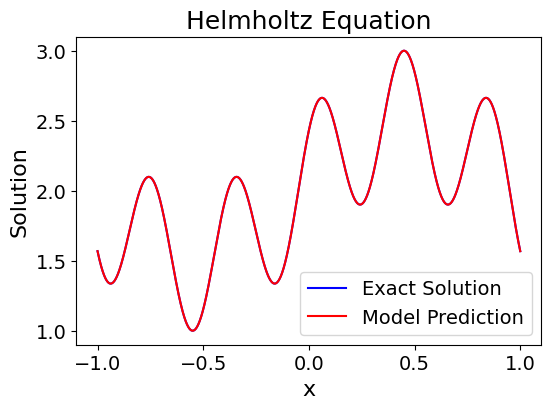

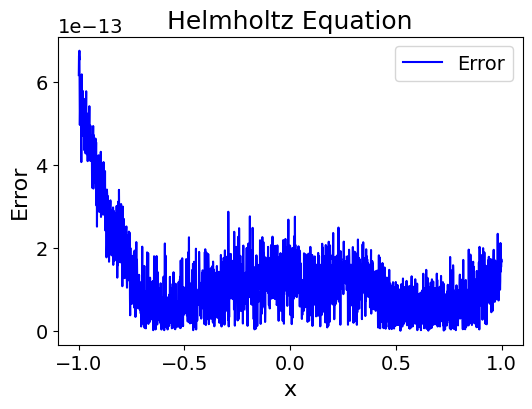

the error of least square in problem helmholtz1d:  5.007020559144858e-13
the condition number of matrix A in problem helmholtz1d:  2.676445407414117e+16
the rank of matrix A in problem helmholtz1d:  107
the maximum pointwise error in problem helmholtz1d:  1.000532989792191e-12
the l2 relative error in problem helmholtz1d:  2.298062234349971e-13


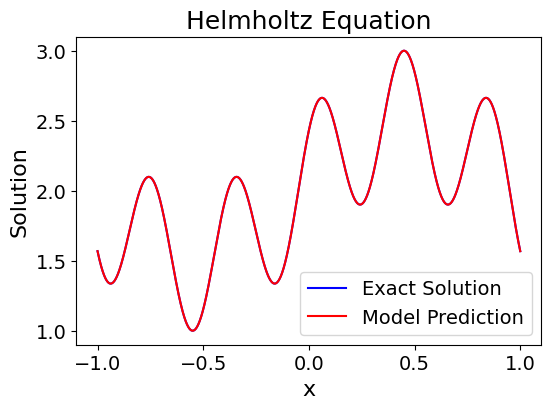

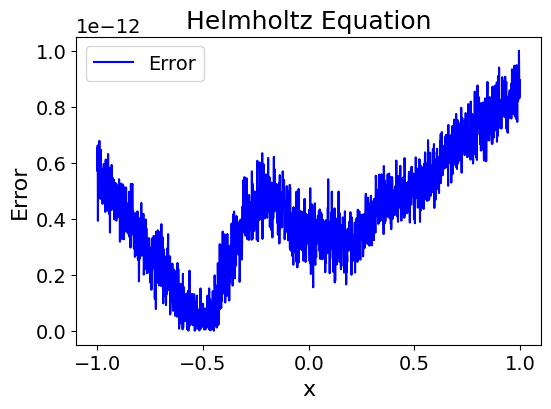

In [ ]:
Pro = problem.Helmholtz(f, u_exact, u_exact, -1, 1)

params = {"radius": 1, "d": 1, "dd": 200, "bodyBatch": 1000, "bdryBatch":2, "lr": 0.001, "width": 200, "depth": 2, "trainStep": 200, "bdry_penalty": 1, "numberoftest": 3000, "writeStep": 200, "plotStep": 300, "lsStep": 10, "step_size": 5000, "milestone": [2000,6000,10000], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-6, "beta": 1, "orthogonalpenalty": 0}


startTime = time.time()
model = net.PD_OFM(params,initialization="uniform").to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])

startTime = time.time()
error_l2s, error_l2_rels, interior_losses = trainnew(model,Pro,device,params,optimizer,scheduler) 

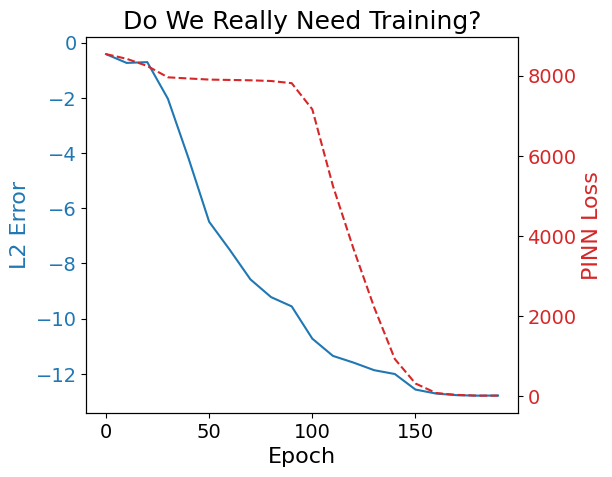

In [ ]:
x = np.array(range(len(error_l2s)))*10
y1 = np.log10(error_l2s)
y2 = interior_losses
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error', color=color)
ax1.plot(x, y1, color=color, label='L2 Error')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 共享 x 轴
color = 'tab:red'
ax2.set_ylabel('PINN Loss', color=color)
ax2.plot(x, y2, color=color, linestyle='--', label='PINN Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Do We Really Need Training?")
plt.show()